# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import os
import pandas as pd
from typing import Dict
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-11-21 02:31:46,412 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_simulated_weekly.csv"
)

dt_prophet_holidays = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_prophet_holidays.csv"
)

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-11-21 02:31:48,504 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-11-21 02:31:48,507 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-11-21 02:31:48,507 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2024-11-21 02:31:49,190 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/tmptrosr5r4/qtdamj3e.json
2024-11-21 02:31:49,200 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnw

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt
%matplotlib inline

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters, featurized_mmmdata=featurized_mmm_data)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result["channel"]
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-11-21 02:31:49,411 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-21 02:31:49,412 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-21 02:31:49,412 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-11-21 02:31:49,413 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: FeaturizedMMMData(dt_mod=            ds       dep_var         trend        season       holiday  \
0   2015-11-23  2.754372e+06  1.716264e+06  1.133548e+06       0.00000   
1   2015-11-30  2.584277e+06  1.717329e+06  8.990713e+05       0.00000   
2   2015-12-07  2.547387e+06  1.718393e+06  7.075011e+05       0.00000   
3   2015-12-14  2.875220e+06  1.719458e+06  6.933337e+05       0.00000   
4   2015-12-21  2.215953e+06  1.720523e+06  8.031644e+05  483714.32256   
..         ...           ...           ...           ...           ...   
203 2

Skipping facebook_I: No spend-exposure data available for channel: FeaturizedMMMData(dt_mod=            ds       dep_var         trend        season       holiday  \
0   2015-11-23  2.754372e+06  1.716264e+06  1.133548e+06       0.00000   
1   2015-11-30  2.584277e+06  1.717329e+06  8.990713e+05       0.00000   
2   2015-12-07  2.547387e+06  1.718393e+06  7.075011e+05       0.00000   
3   2015-12-14  2.875220e+06  1.719458e+06  6.933337e+05       0.00000   
4   2015-12-21  2.215953e+06  1.720523e+06  8.031644e+05  483714.32256   
..         ...           ...           ...           ...           ...   
203 2019-10-14  2.456240e+06  1.743483e+06  7.429261e+05       0.00000   
204 2019-10-21  2.182825e+06  1.742720e+06  7.979784e+05       0.00000   
205 2019-10-28  2.377707e+06  1.741957e+06  8.621816e+05       0.00000   
206 2019-11-04  2.732825e+06  1.741194e+06  1.003188e+06       0.00000   
207 2019-11-11  2.767788e+06  1.740432e+06  1.171096e+06       0.00000   

     competitor_sal

2024-11-21 02:31:49,505 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-11-21 02:31:49,507 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-11-21 02:31:49,507 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-11-21 02:31:49,508 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-11-21 02:31:49,508 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-11-21 02:31:49,508 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-11-21 02:31:49,509 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-11-21 02:31:49,509 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization...


>>> Starting 5 trials with 54 iterations each using TwoPointsDE nevergrad algorithm on x cores...


Running trial 1 of total 5 trials:   2%|▋                                  

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44542.944419
2     31735.192527
3    106060.451951
4     75564.130437
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44542.944419
2     31735.192527
3    106060.451951
4     75564.130437
Name: tv_S, dtype: float64
After hill: 0    0.140532
1    0.256981
2    0.193572
3    0.464101
4    0.377434
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     26382.875082
4    282598.054104
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     26382.875082
4    282598.054104
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.292209
3    0.071766
4    0.476043
Name: ooh_S, dty

Running trial 1 of total 5 trials:   6%|█▉                                 

After adstock: 0     22358.346667
1     44633.318387
2     31979.991550
3    106364.127473
4     76210.419047
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44633.318387
2     31979.991550
3    106364.127473
4     76210.419047
Name: tv_S, dtype: float64
After hill: 0    0.052576
1    0.121773
2    0.082179
3    0.297718
4    0.216780
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     29389.494000
4    283865.730913
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     29389.494000
4    283865.730913
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.406004
3    0.086994
4    0.650148
Name: ooh_S, dtype: float64
Before adstock: 0    12728.488889
1        0.000000
2      453.866667
3    17680.000000
4        0.000000
Name: print_S, 

Running trial 1 of total 5 trials:   9%|███▏                               

Model coefficients:
[0.16672615 0.28459481 1.69437949 0.30118323 1.68317898 0.06920169
 1.37485446 0.34819848 0.56945091 1.12686613 0.57655861 0.65704947]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38326.466222
2    16649.954755
3    90683.454428
4    39395.111580
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38326.466222
2    16649.954755
3    90683.454428
4    39395.111580
Name: tv_S, dtype: float64
After hill: 0    0.118245
1    0.329964
2    0.061754
3    0.797354
4    0.344799
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     42900.330443
4    291249.370226
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     42900.330443


Running trial 1 of total 5 trials:  15%|█████▏                             

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42175.275591
2    25582.105858
3    98967.552990
4    60030.394149
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42175.275591
2    25582.105858
3    98967.552990
4    60030.394149
Name: tv_S, dtype: float64
After hill: 0    0.128944
1    0.220718
2    0.145258
3    0.402870
4    0.288668
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     44385.642111
4    292229.476377
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     44385.642111
4    292229.476377
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.208142
3    0.021111
4    0.617467
Name: ooh_S, dtype: float6

Running trial 1 of total 5 trials:  19%|██████▍                            

After adstock: 0       0.000000
1    4133.333333
2    4225.727069
3    4702.208195
4    4112.822065
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4225.727069
3    4702.208195
4    4112.822065
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.102748
2    0.105695
3    0.121003
4    0.102096
Name: search_S, dtype: float64
Model coefficients:
[0.0110188  0.00681424 0.15837326 0.02814915 0.15716084 0.00756368
 0.1406822  0.0307886  0.04472409 0.06764248 0.07160175 0.05942036]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40471.040995
2    21463.524271
3    94833.331733
4    50294.172507
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40471.040995
2    21463.524271
3    94833.331733
4    50294.172507
Name: tv_S, dtype: float64
After hill: 0    0.020258
1    0.068626
2    0.018591
3    0.312845
4    0.10

Running trial 1 of total 5 trials:  22%|███████▊                           

Model coefficients:
[-0.01419726  0.01189044  0.26533503  0.06056274  0.2617796  -0.03358964
  0.17118749  0.07622918  0.09202463  0.13965322  0.09597792  0.08790998]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45577.403857
2     34580.948025
3    109687.912697
4     83223.520582
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45577.403857
2     34580.948025
3    109687.912697
4     83223.520582
Name: tv_S, dtype: float64
After hill: 0    0.005639
1    0.041145
2    0.019568
3    0.309489
4    0.178024
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     14346.534208
4    278891.983772
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 1 of total 5 trials:  26%|█████████                          

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41441.564124
2    23777.114823
3    97092.436283
4    55706.826099
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41441.564124
2    23777.114823
3    97092.436283
4    55706.826099
Name: tv_S, dtype: float64
After hill: 0    0.263420
1    0.353022
2    0.271687
3    0.493876
4    0.400434
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     20163.042675
4    280409.429146
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     20163.042675
4    280409.429146
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.224031
3    0.002688
4    0.651270
Name: ooh_S, dtype: float6

Running trial 1 of total 5 trials:  30%|██████████▎                        

Model coefficients:
[ 0.00821636  0.0132989   0.08148052  0.01358911  0.08173953 -0.00974703
  0.05428915  0.01183878  0.02529732  0.04810988  0.03733237  0.02709391]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35489.088428
2    10913.598644
3    86806.454729
4    26694.706699
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35489.088428
2    10913.598644
3    86806.454729
4    26694.706699
Name: tv_S, dtype: float64
After hill: 0    0.028398
1    0.066674
2    0.007247
3    0.287238
4    0.039553
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     14604.516763
4    278948.447005
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     1

Running trial 1 of total 5 trials:  35%|████████████▎                      

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38861.229882
2    17811.746377
3    91614.183877
4    41990.657854
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38861.229882
2    17811.746377
3    91614.183877
4    41990.657854
Name: tv_S, dtype: float64
After hill: 0    0.073509
1    0.272907
2    0.040181
3    0.806911
4    0.318161
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     23905.355870
4    281656.176531
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     23905.355870
4    281656.176531
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.243198
3    0.053298
4    0.409574
Name: ooh_S, dtype: float6

Running trial 1 of total 5 trials:  39%|█████████████▌                     

After adstock: 0       0.000000
1    4133.333333
2    4114.270111
3    4579.425848
4    3976.293579
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4114.270111
3    4579.425848
4    3976.293579
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.280287
2    0.278470
3    0.322353
4    0.265291
Name: search_S, dtype: float64
Model coefficients:
[-0.02203415  0.02367621  0.48388328  0.11007374  0.47716692 -0.03905337
  0.21393516  0.12232144  0.19129356  0.27658172  0.18998882  0.15976924]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37870.997357
2    15680.606017
3    89942.911093
4    37241.146294
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37870.997357
2    15680.606017
3    89942.911093
4    37241.146294
Name: tv_S, dtype: float64
After hill: 0    0.020547
1    0.060080
2    0.009810
3    0.2846

Running trial 1 of total 5 trials:  43%|██████████████▉                    

Before hill: 0    7607.132915
1    1496.340099
2    4326.084223
3    3002.026634
4     829.435710
Name: facebook_S, dtype: float64
After hill: 0    0.315866
1    0.059052
2    0.187622
3    0.128537
4    0.029523
Name: facebook_S, dtype: float64
Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    3993.270068
3    4452.935715
4    3835.911962
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3993.270068
3    4452.935715
4    3835.911962
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.106838
2    0.098799
3    0.126189
4    0.090108
Name: search_S, dtype: float64
Model coefficients:
[0.04212011 0.06774645 0.34775816 0.0606125  0.34556136 0.00655301
 0.17339399 0.08156127 0.12172034 0.19746168 0.15538447 0.13568851]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4     

Running trial 1 of total 5 trials:  46%|████████████████▏                  

Model coefficients:
[0.0118043  0.01898371 0.09751891 0.01700252 0.09687771 0.00277271
 0.08129155 0.0218223  0.03629832 0.05487704 0.04157398 0.03785667]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36568.510568
2    13011.006534
3    88079.598054
4    31338.553525
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36568.510568
2    13011.006534
3    88079.598054
4    31338.553525
Name: tv_S, dtype: float64
After hill: 0    0.181553
1    0.260963
2    0.117379
3    0.447602
4    0.233831
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     32859.279959
4    285498.574384
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     32859.279959


Running trial 1 of total 5 trials:  52%|██████████████████▏                

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46084.220131
2     36010.116266
3    111588.538577
4     87195.058019
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46084.220131
2     36010.116266
3    111588.538577
4     87195.058019
Name: tv_S, dtype: float64
After hill: 0    0.001881
1    0.018860
2    0.008912
3    0.202440
4    0.111530
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     41793.097641
4    290540.446156
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     41793.097641
4    290540.446156
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.085381
3    0.003490
4    0.467677
Name: ooh_S, dty

Running trial 1 of total 5 trials:  56%|███████████████████▍               

Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    4718.564204
3    5317.176485
4    4812.139060
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4718.564204
3    5317.176485
4    4812.139060
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.135541
2    0.181289
3    0.232137
4    0.189011
Name: search_S, dtype: float64
Model coefficients:
[ 0.00178005  0.00208096  0.07086324  0.01008346  0.07110922 -0.00861851
  0.04708497  0.01858053  0.02526973  0.02621955  0.02894061  0.01837833]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45009.184085
2     33005.949618
3    107654.093790
4     78944.456960
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45009.184085
2     3

Running trial 1 of total 5 trials:  59%|████████████████████▋              

Model coefficients:
[0.007119   0.01539579 0.11918511 0.02563797 0.11831833 0.0080114
 0.08825861 0.02638346 0.04337679 0.07949404 0.0569153  0.04337785]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42090.829766
2    25371.909900
3    98744.227351
4    59521.982660
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42090.829766
2    25371.909900
3    98744.227351
4    59521.982660
Name: tv_S, dtype: float64
After hill: 0    0.131650
1    0.252759
2    0.151140
3    0.498235
4    0.343920
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     37674.485787
4    288066.148530
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     37674.485787
4

Running trial 1 of total 5 trials:  63%|██████████████████████             

After adstock: 0       0.000000
1    4133.333333
2    4452.346209
3    4970.390378
4    4413.822170
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4452.346209
3    4970.390378
4    4413.822170
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.124680
2    0.142841
3    0.173711
4    0.140609
Name: search_S, dtype: float64
Model coefficients:
[ 0.06253803  0.20331115  1.962362    0.3901652   1.95208116 -0.01796617
  1.76122396  0.45026922  0.64799206  1.18245581  0.82501423  0.72522482]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38326.466222
2    16649.954755
3    90683.454428
4    39395.111580
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38326.466222
2    16649.954755
3    90683.454428
4    39395.111580
Name: tv_S, dtype: float64
After hill: 0    0.118245
1    0.329964
2    0.061754
3    0.7973

Running trial 1 of total 5 trials:  70%|████████████████████████▋          

Model coefficients:
[ 0.01512619  0.01681984  0.36658724  0.06910125  0.36496809 -0.00997744
  0.31542579  0.07519437  0.11250507  0.17786829  0.12885505  0.13565149]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42175.275591
2    25582.105858
3    98967.552990
4    60030.394149
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42175.275591
2    25582.105858
3    98967.552990
4    60030.394149
Name: tv_S, dtype: float64
After hill: 0    0.030557
1    0.114630
2    0.040833
3    0.461501
4    0.220765
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     26491.609851
4    282641.517700
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 1 of total 5 trials:  74%|█████████████████████████▉         

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35569.478781
2    11066.211793
3    86893.175318
4    27033.802980
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35569.478781
2    11066.211793
3    86893.175318
4    27033.802980
Name: tv_S, dtype: float64
After hill: 0    0.390952
1    0.457343
2    0.298226
3    0.587282
4    0.417764
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     34132.479358
4    286143.380095
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     34132.479358
4    286143.380095
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.230418
3    0.078950
4    0.379058
Name: ooh_S, dtype: float6

Running trial 1 of total 5 trials:  78%|███████████████████████████▏       

Model coefficients:
[-0.00767462  0.00642763  0.14343227  0.03273841  0.14151031 -0.00519817
  0.0925389   0.03566315  0.0497458   0.07549241  0.05188283  0.04752153]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37481.617823
2    14866.624851
3    89346.971413
4    35438.382406
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37481.617823
2    14866.624851
3    89346.971413
4    35438.382406
Name: tv_S, dtype: float64
After hill: 0    0.238094
1    0.353268
2    0.167379
3    0.582768
4    0.339552
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     26579.062560
4    282676.604109
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 1 of total 5 trials:  81%|████████████████████████████▌      

Model coefficients:
[-0.00058407  0.00568732  0.12103457  0.0253737   0.1208775  -0.00880776
  0.10991347  0.02064016  0.03387145  0.05843131  0.0473704   0.04532639]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41441.564124
2    23777.114823
3    97092.436283
4    55706.826099
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41441.564124
2    23777.114823
3    97092.436283
4    55706.826099
Name: tv_S, dtype: float64
After hill: 0    0.263420
1    0.353022
2    0.271687
3    0.493876
4    0.400434
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     20163.042675
4    280409.429146
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 1 of total 5 trials:  85%|█████████████████████████████▊     

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35489.088428
2    10913.598644
3    86806.454729
4    26694.706699
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35489.088428
2    10913.598644
3    86806.454729
4    26694.706699
Name: tv_S, dtype: float64
After hill: 0    0.028398
1    0.066674
2    0.007247
3    0.287238
4    0.039553
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     14604.516763
4    278948.447005
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     14604.516763
4    278948.447005
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.247397
3    0.001221
4    0.686035
Name: ooh_S, dtype: float6

Running trial 1 of total 5 trials:  93%|████████████████████████████████▍  

Model coefficients:
[-0.00524214  0.00393163  0.09139526  0.02091373  0.09012472  0.00354367
  0.06524964  0.0208555   0.03161218  0.05241452  0.03128928  0.03013965]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35380.284870
2    10707.966515
3    86691.110049
4    26237.366572
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35380.284870
2    10707.966515
3    86691.110049
4    26237.366572
Name: tv_S, dtype: float64
After hill: 0    0.223662
1    0.298546
2    0.133493
3    0.476950
4    0.248165
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     28896.678088
4    283648.580168
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 1 of total 5 trials:  96%|█████████████████████████████████▋ 

After hill: 0    0.772244
1    0.079329
2    0.461710
3    0.271837
4    0.017812
Name: facebook_S, dtype: float64
Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    3825.255942
3    4289.046363
4    3653.376363
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3825.255942
3    4289.046363
4    3653.376363
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.101291
2    0.088908
3    0.107726
4    0.082221
Name: search_S, dtype: float64
Model coefficients:
[-0.00375484  0.01427881  0.2166062   0.04897338  0.21357772  0.0086215
  0.14594436  0.04618812  0.07661176  0.11745193  0.07830637  0.07301997]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     42589.913498
2     26623.445744
3    1000

Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-11-21 02:31:55,889 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.10 mins


Model coefficients:
[ 0.00451958  0.01469304  0.1418158   0.02819615  0.1410728  -0.02978442
  0.12705957  0.02278709  0.06097516  0.08981438  0.04988942  0.05241057]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37677.723944
2    15274.881051
3    89642.877945
4    36342.012053
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37677.723944
2    15274.881051
3    89642.877945
4    36342.012053
Name: tv_S, dtype: float64
After hill: 0    0.010047
1    0.035322
2    0.003961
3    0.235659
4    0.032420
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36860.150215
4    287607.296552
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 2 of total 5 trials:   0%|                                   

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41546.385932
2    24032.036759
3    97351.366358
4    56311.796139
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41546.385932
2    24032.036759
3    97351.366358
4    56311.796139
Name: tv_S, dtype: float64
After hill: 0    0.239010
1    0.345893
2    0.250244
3    0.519161
4    0.405640
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36255.441499
4    287273.049725
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     36255.441499
4    287273.049725
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.131226
3    0.011280
4    0.415232
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:   4%|█▎                                 

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46260.989982
2     36513.993108
3    112270.954327
4     88615.934379
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46260.989982
2     36513.993108
3    112270.954327
4     88615.934379
Name: tv_S, dtype: float64
After hill: 0    0.133366
1    0.265494
2    0.217236
3    0.478304
4    0.418513
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     37282.156477
4    287843.831903
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     37282.156477
4    287843.831903
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.378916
3    0.233369
4    0.483178
Name: ooh_S, dty

Running trial 2 of total 5 trials:   6%|█▉                                 

Model coefficients:
[-0.1591609   0.22805697  4.26111883  0.96708127  4.20447614  0.43708333
  2.43743854  0.68191077  1.45545266  2.25220497  1.53846556  1.41382343]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40705.865831
2    22015.586754
3    95357.338988
4    51573.593296
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40705.865831
2    22015.586754
3    95357.338988
4    51573.593296
Name: tv_S, dtype: float64
After hill: 0    0.004374
1    0.023180
2    0.004188
3    0.206125
4    0.044127
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45887.704833
4    293254.558547
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 2 of total 5 trials:   7%|██▌                                

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40375.156575
2    21239.522630
3    94623.447772
4    49777.066660
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40375.156575
2    21239.522630
3    94623.447772
4    49777.066660
Name: tv_S, dtype: float64
After hill: 0    0.004923
1    0.025398
2    0.004264
3    0.221639
4    0.044814
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     38505.571841
4    288544.776813
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     38505.571841
4    288544.776813
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.329588
3    0.132489
4    0.507199
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  11%|███▉                               

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40766.294139
2    22158.448937
3    95494.493406
4    51905.867349
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40766.294139
2    22158.448937
3    95494.493406
4    51905.867349
Name: tv_S, dtype: float64
After hill: 0    0.018486
1    0.071982
2    0.018105
3    0.364909
4    0.120466
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36724.279184
4    287531.713598
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     36724.279184
4    287531.713598
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.290818
3    0.041932
4    0.614017
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  13%|████▌                              

Model coefficients:
[ 0.13798905  0.2233473   1.36842278  0.22822339  1.37277286 -0.05860391
  0.94497157  0.34736041  0.50026696  0.92645141  0.56974816  0.45502776]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37229.296486
2    14346.399758
3    88978.726632
4    34288.168262
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37229.296486
2    14346.399758
3    88978.726632
4    34288.168262
Name: tv_S, dtype: float64
After hill: 0    0.092882
1    0.191829
2    0.046947
3    0.499598
4    0.171667
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     27269.262411
4    282957.572928
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 2 of total 5 trials:  17%|█████▊                             

Model coefficients:
[ 0.00180469  0.00210977  0.0718443   0.01022306  0.07209368 -0.00098578
  0.04888319  0.01542434  0.02578254  0.03067646  0.02162555  0.01863276]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38616.554534
2    17277.006604
3    91180.021573
4    40793.847455
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38616.554534
2    17277.006604
3    91180.021573
4    40793.847455
Name: tv_S, dtype: float64
After hill: 0    0.006054
1    0.026935
2    0.002972
3    0.230120
4    0.031217
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45411.106828
4    292925.609666
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 2 of total 5 trials:  20%|███████▏                           

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38587.236035
2    17213.290098
3    91128.943087
4    40651.497615
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38587.236035
2    17213.290098
3    91128.943087
4    40651.497615
Name: tv_S, dtype: float64
After hill: 0    0.096353
1    0.282973
2    0.053874
3    0.755903
4    0.308997
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     30336.457736
4    284293.301177
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     30336.457736
4    284293.301177
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.164822
3    0.006049
4    0.546065
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  22%|███████▊                           

After adstock: 0       0.000000
1    4133.333333
2    4192.760288
3    4665.265562
4    4071.688476
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4192.760288
3    4665.265562
4    4071.688476
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.165961
2    0.168542
3    0.188874
4    0.163278
Name: search_S, dtype: float64
Model coefficients:
[0.00035138 0.00623838 0.07636179 0.01732036 0.07578874 0.00598728
 0.06502878 0.02088457 0.03014079 0.04500606 0.02952746 0.02635825]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41379.399905
2    23626.398510
3    96940.272877
4    55349.993569
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41379.399905
2    23626.398510
3    96940.272877
4    55349.993569
Name: tv_S, dtype: float64
After hill: 0    0.267040
1    0.365495
2    0.275165
3    0.520054
4    0.41

Running trial 2 of total 5 trials:  24%|████████▍                          

After adstock: 0       0.000000
1    4133.333333
2    4804.113173
3    5435.896599
4    4951.414141
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4804.113173
3    5435.896599
4    4951.414141
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.053370
2    0.073761
3    0.095646
4    0.078642
Name: search_S, dtype: float64
Model coefficients:
[-0.00441182  0.0099168   0.16547008  0.03746032  0.16294003 -0.00964548
  0.14222669  0.02693479  0.05619596  0.10029228  0.05893703  0.05524954]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37207.945781
2    14302.641146
3    88948.206093
4    34191.467593
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37207.945781
2    14302.641146
3    88948.206093
4    34191.467593
Name: tv_S, dtype: float64
After hill: 0    0.050439
1    0.156566
2    0.017414
3    0.6122

Running trial 2 of total 5 trials:  26%|█████████                          

Model coefficients:
[ 0.00606529  0.01292478  0.27499969  0.05441039  0.27591561 -0.02684223
  0.17254569  0.05450825  0.07606202  0.14941372  0.10176044  0.10455477]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39238.944516
2    18647.758941
3    92312.392990
4    43870.172173
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39238.944516
2    18647.758941
3    92312.392990
4    43870.172173
Name: tv_S, dtype: float64
After hill: 0    0.016083
1    0.055911
2    0.010673
3    0.295365
4    0.071015
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43402.207930
4    291576.810693
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 2 of total 5 trials:  28%|█████████▋                         

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35774.340658
2    11457.735510
3    87119.967675
4    27902.612010
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35774.340658
2    11457.735510
3    87119.967675
4    27902.612010
Name: tv_S, dtype: float64
After hill: 0    0.151074
1    0.216724
2    0.086753
3    0.389562
4    0.179727
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     24011.930433
4    281694.782712
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     24011.930433
4    281694.782712
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.078959
3    0.000821
4    0.401828
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  31%|███████████                        

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42512.742611
2    26428.470600
3    99879.829096
4    62091.292273
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42512.742611
2    26428.470600
3    99879.829096
4    62091.292273
Name: tv_S, dtype: float64
After hill: 0    0.006055
1    0.037555
2    0.009795
3    0.312171
4    0.103949
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     30799.607484
4    284507.358447
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     30799.607484
4    284507.358447
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.122599
3    0.015387
4    0.306431
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  33%|███████████▋                       

Before hill: 0       0.000000
1    4133.333333
2    4918.655100
3    5600.396402
4    5147.103644
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.057350
2    0.076732
3    0.094931
4    0.082701
Name: search_S, dtype: float64
Model coefficients:
[0.0296752  0.04783097 0.25254862 0.04440078 0.25108993 0.0152571
 0.17695405 0.06441424 0.08782616 0.14608734 0.10361914 0.0985972 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37805.298750
2    15542.314789
3    89839.981051
4    36934.538604
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37805.298750
2    15542.314789
3    89839.981051
4    36934.538604
Name: tv_S, dtype: float64
After hill: 0    0.005600
1    0.026250
2    0.001901
3    0.262425
4    0.024531
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, d

Running trial 2 of total 5 trials:  35%|████████████▎                      

After adstock: 0       0.000000
1    4133.333333
2    3956.093061
3    4415.494603
4    3794.325590
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3956.093061
3    4415.494603
4    3794.325590
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.034949
2    0.031563
3    0.040717
4    0.028635
Name: search_S, dtype: float64
Model coefficients:
[0.00732947 0.01178729 0.06055102 0.01055713 0.06015289 0.00281678
 0.03200014 0.01334788 0.02003639 0.02351328 0.02092531 0.0235058 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38781.425766
2    17636.745417
3    91471.022325
4    41598.551417
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38781.425766
2    17636.745417
3    91471.022325
4    41598.551417
Name: tv_S, dtype: float64
After hill: 0    0.093206
1    0.208969
2    0.064054
3    0.534704
4    0.22

Running trial 2 of total 5 trials:  37%|████████████▉                      

Model coefficients:
[-0.0372779   0.02663832  0.63027044  0.14444073  0.62117501  0.05275774
  0.45440624  0.11251337  0.22561225  0.3624422   0.12901191  0.20817471]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36142.805164
2    12171.378336
3    87549.115542
4    29482.863972
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36142.805164
2    12171.378336
3    87549.115542
4    29482.863972
Name: tv_S, dtype: float64
After hill: 0    0.354679
1    0.435619
2    0.263373
3    0.590625
4    0.400601
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     40252.939306
4    289585.158765
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 2 of total 5 trials:  39%|█████████████▌                     

Model coefficients:
[-0.01052926  0.00752407  0.17802176  0.04079764  0.17545272 -0.01463032
  0.13458578  0.04502574  0.05757694  0.10463399  0.05994529  0.05879958]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45776.711134
2     35140.232244
3    110425.506317
4     84767.512596
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45776.711134
2     35140.232244
3    110425.506317
4     84767.512596
Name: tv_S, dtype: float64
After hill: 0    0.165832
1    0.297202
2    0.243995
3    0.500380
4    0.437065
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     38670.811778
4    288641.184244
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 2 of total 5 trials:  41%|██████████████▎                    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44191.690975
2     30790.678490
3    104903.793984
4     73091.998104
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44191.690975
2     30790.678490
3    104903.793984
4     73091.998104
Name: tv_S, dtype: float64
After hill: 0    0.017518
1    0.067172
2    0.033356
3    0.289884
4    0.165485
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     32764.161985
4    285451.386266
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     32764.161985
4    285451.386266
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.381724
3    0.226471
4    0.482252
Name: ooh_S, dty

Running trial 2 of total 5 trials:  43%|██████████████▉                    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37230.291594
2    14348.440242
3    88980.151547
4    34292.677616
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37230.291594
2    14348.440242
3    88980.151547
4    34292.677616
Name: tv_S, dtype: float64
After hill: 0    0.199063
1    0.297636
2    0.135128
3    0.513261
4    0.279976
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     13776.867951
4    278770.868358
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     13776.867951
4    278770.868358
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.271026
3    0.006164
4    0.588964
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  44%|███████████████▌                   

Model coefficients:
[-0.00394172  0.01498946  0.22738671  0.0514108   0.2242075  -0.01920771
  0.17098517  0.04196258  0.08157134  0.13314606  0.09679573  0.07665418]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38221.534173
2    16424.988646
3    90508.637994
4    38894.392484
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38221.534173
2    16424.988646
3    90508.637994
4    38894.392484
Name: tv_S, dtype: float64
After hill: 0    0.057327
1    0.198605
2    0.026386
3    0.703312
4    0.205982
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     27424.146733
4    283021.613252
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 2 of total 5 trials:  46%|████████████████▏                  

Model coefficients:
[ 0.00771747  0.01375659  0.08744517  0.01878149  0.08666455 -0.00343149
  0.06172573  0.0210295   0.02900873  0.04598088  0.03849589  0.03216216]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45859.967176
2     35374.912578
3    110737.383325
4     85419.277323
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45859.967176
2     35374.912578
3    110737.383325
4     85419.277323
Name: tv_S, dtype: float64
After hill: 0    0.009199
1    0.051322
2    0.028382
3    0.285487
4    0.183073
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     20401.966813
4    280482.698553
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 2 of total 5 trials:  48%|████████████████▊                  

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44035.954898
2     30375.438463
3    104402.895613
4     72015.782068
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44035.954898
2     30375.438463
3    104402.895613
4     72015.782068
Name: tv_S, dtype: float64
After hill: 0    0.086125
1    0.181893
2    0.122245
3    0.394060
4    0.291056
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45913.325768
4    293272.339441
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45913.325768
4    293272.339441
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.234994
3    0.081272
4    0.439388
Name: ooh_S, dty

Running trial 2 of total 5 trials:  52%|██████████████████▏                

Model coefficients:
[ 0.01570234  0.02522315  0.12875141  0.02241038  0.12793369 -0.00419267
  0.11420975  0.03387105  0.04640221  0.08703363  0.06047495  0.05024695]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     43057.413915
2     27815.991881
3    101420.020451
4     65519.458995
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     43057.413915
2     27815.991881
3    101420.020451
4     65519.458995
Name: tv_S, dtype: float64
After hill: 0    0.012245
1    0.045365
2    0.019063
3    0.213250
4    0.100478
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     47287.519436
4    294240.570167
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 2 of total 5 trials:  56%|███████████████████▍               

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     43880.614938
2     29963.415880
3    103910.509708
4     70954.197454
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     43880.614938
2     29963.415880
3    103910.509708
4     70954.197454
Name: tv_S, dtype: float64
After hill: 0    0.262219
1    0.371374
2    0.307355
3    0.528175
4    0.457829
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     29810.154508
4    284053.992596
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     29810.154508
4    284053.992596
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.205428
3    0.009701
4    0.580796
Name: ooh_S, dty

Running trial 2 of total 5 trials:  57%|████████████████████               

Model coefficients:
[ 0.00996971  0.01606934  0.08484647  0.01491692  0.08435641 -0.01294114
  0.07441754  0.01882858  0.02731505  0.05453896  0.0379084   0.03312481]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35339.997425
2    10632.094333
3    86648.989127
4    26068.485947
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35339.997425
2    10632.094333
3    86648.989127
4    26068.485947
Name: tv_S, dtype: float64
After hill: 0    0.077735
1    0.150238
2    0.024691
3    0.430074
4    0.097519
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     37282.156477
4    287843.831903
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 2 of total 5 trials:  59%|████████████████████▋              

Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    4680.502229
3    5265.494464
4    4751.999351
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4680.502229
3    5265.494464
4    4751.999351
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.289607
2    0.334254
3    0.379493
4    0.339929
Name: search_S, dtype: float64
Model coefficients:
[0.00219471 0.0107086  0.11544864 0.02306694 0.11528014 0.00288677
 0.07411853 0.02754204 0.03872847 0.06893704 0.05234199 0.04199493]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35516.297988
2    10965.188588
3    86835.664026
4    26809.366013
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35516.297988
2    10965.188588
3    868

Running trial 2 of total 5 trials:  61%|█████████████████████▍             

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39486.820635
2    19203.329777
3    92789.318231
4    45125.534271
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39486.820635
2    19203.329777
3    92789.318231
4    45125.534271
Name: tv_S, dtype: float64
After hill: 0    0.018926
1    0.087070
2    0.012423
3    0.512275
4    0.121848
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     24126.218379
4    281736.373858
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     24126.218379
4    281736.373858
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.222612
3    0.007973
4    0.583497
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  65%|██████████████████████▋            

After hill: 0    0.673455
1    0.246609
2    0.481151
3    0.377679
4    0.103485
Name: facebook_S, dtype: float64
Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    3956.811522
3    4416.211831
4    3795.122621
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3956.811522
3    4416.211831
4    3795.122621
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.041441
2    0.037033
3    0.049098
4    0.033242
Name: search_S, dtype: float64
Model coefficients:
[ 0.00789053  0.01269174  0.06523456  0.01137525  0.06480782 -0.01204745
  0.04391635  0.01099217  0.0259004   0.04452933  0.02340896  0.02532082]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41701.274562
2    24410.518123
3    97739.

Running trial 2 of total 5 trials:  69%|███████████████████████▉           

Model coefficients:
[0.00539248 0.02631146 0.28366214 0.05667647 0.28324812 0.01496142
 0.19379214 0.07148974 0.09844749 0.17408673 0.10640828 0.10318328]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39004.889951
2    18128.211703
3    91875.713326
4    42700.860934
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39004.889951
2    18128.211703
3    91875.713326
4    42700.860934
Name: tv_S, dtype: float64
After hill: 0    0.026609
1    0.072267
2    0.018086
3    0.280716
4    0.084551
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     16162.535595
4    279310.831544
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     16162.535595


Running trial 2 of total 5 trials:  72%|█████████████████████████▎         


[0.01401983 0.02259739 0.11931469 0.02097681 0.11862554 0.02159832
 0.10183102 0.03343598 0.04115573 0.08020405 0.0493875  0.04658151]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35952.307697
2    11800.906129
3    87323.810049
4    28662.974681
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35952.307697
2    11800.906129
3    87323.810049
4    28662.974681
Name: tv_S, dtype: float64
After hill: 0    0.014786
1    0.045452
2    0.003165
3    0.291621
4    0.026717
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45411.106828
4    292925.609666
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45411.106828
4    292925.609666


Running trial 2 of total 5 trials:  76%|██████████████████████████▌        

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38114.692661
2    16196.940779
3    90333.240052
4    38387.352418
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38114.692661
2    16196.940779
3    90333.240052
4    38387.352418
Name: tv_S, dtype: float64
After hill: 0    0.097068
1    0.278606
2    0.047276
3    0.753436
4    0.282054
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     17889.203125
4    279755.318562
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     17889.203125
4    279755.318562
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.130888
3    0.000581
4    0.546651
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  78%|███████████████████████████▏       

Model coefficients:
[ 0.00633108  0.01020454  0.05388019  0.00947271  0.05356898 -0.00356889
  0.04826421  0.01392543  0.01775983  0.03721316  0.01535466  0.0210353 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40600.068534
2    21766.251589
3    95119.491605
4    50994.859369
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40600.068534
2    21766.251589
3    95119.491605
4    50994.859369
Name: tv_S, dtype: float64
After hill: 0    0.153998
1    0.243365
2    0.150687
3    0.419911
4    0.285565
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     17263.847825
4    279589.130078
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     1

Running trial 2 of total 5 trials:  80%|███████████████████████████▊       

After adstock: 0       0.000000
1    4133.333333
2    4649.885438
3    5224.430526
4    4704.420390
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4649.885438
3    5224.430526
4    4704.420390
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.036626
2    0.048976
3    0.065011
4    0.050395
Name: search_S, dtype: float64
Model coefficients:
[ 0.01141785  0.02001761  0.1248275   0.02209674  0.12389309 -0.01328679
  0.10144426  0.01794612  0.04022557  0.08824644  0.04600884  0.04786682]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40406.524518
2    21312.712745
3    94691.850699
4    49945.899513
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40406.524518
2    21312.712745
3    94691.850699
4    49945.899513
Name: tv_S, dtype: float64
After hill: 0    0.119890
1    0.300986
2    0.110396
3    0.6924

Running trial 2 of total 5 trials:  81%|████████████████████████████▌      

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39238.944516
2    18647.758941
3    92312.392990
4    43870.172173
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39238.944516
2    18647.758941
3    92312.392990
4    43870.172173
Name: tv_S, dtype: float64
After hill: 0    0.016083
1    0.055911
2    0.010673
3    0.295365
4    0.071015
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43402.207930
4    291576.810693
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     43402.207930
4    291576.810693
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.337063
3    0.156613
4    0.509494
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  83%|█████████████████████████████▏     

Model coefficients:
[-0.00528458  0.01187855  0.19820364  0.04487078  0.1951731   0.02585093
  0.12004557  0.05986869  0.07229075  0.10159287  0.05216585  0.0661791 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35774.340658
2    11457.735510
3    87119.967675
4    27902.612010
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35774.340658
2    11457.735510
3    87119.967675
4    27902.612010
Name: tv_S, dtype: float64
After hill: 0    0.151074
1    0.216724
2    0.086753
3    0.389562
4    0.179727
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     35929.484425
4    287095.173463
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 2 of total 5 trials:  87%|██████████████████████████████▍    

After adstock: 0       0.000000
1    4133.333333
2    4105.919703
3    4570.468979
4    3966.350132
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4105.919703
3    4570.468979
4    3966.350132
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.119796
2    0.118611
3    0.138964
4    0.112617
Name: search_S, dtype: float64
Model coefficients:
[ 0.00385578  0.00450757  0.15349736  0.02184186  0.15403017 -0.00605177
  0.10611387  0.04979481  0.05484562  0.08374961  0.05124007  0.03980941]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36500.245862
2    12875.275201
3    87991.994197
4    31038.726288
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36500.245862
2    12875.275201
3    87991.994197
4    31038.726288
Name: tv_S, dtype: float64
After hill: 0    0.216716
1    0.322038
2    0.130840
3    0.5562

Running trial 2 of total 5 trials:  91%|███████████████████████████████▊   

Model coefficients:
[ 0.00622458  0.01109547  0.0705295   0.01514834  0.06989989 -0.00024451
  0.04104896  0.01907     0.02298958  0.02787182  0.02713462  0.02594061]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38781.425766
2    17636.745417
3    91471.022325
4    41598.551417
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38781.425766
2    17636.745417
3    91471.022325
4    41598.551417
Name: tv_S, dtype: float64
After hill: 0    0.093206
1    0.208969
2    0.064054
3    0.534704
4    0.229527
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     29191.468324
4    283778.033037
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 2 of total 5 trials:  94%|█████████████████████████████████  

Model coefficients:
[-0.0372779   0.02663832  0.63027043  0.14444074  0.621175   -0.03050334
  0.45440624  0.12988044  0.22561227  0.36244218  0.12901191  0.20817471]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36142.805164
2    12171.378336
3    87549.115542
4    29482.863972
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36142.805164
2    12171.378336
3    87549.115542
4    29482.863972
Name: tv_S, dtype: float64
After hill: 0    0.252779
1    0.384868
2    0.134417
3    0.660104
4    0.325262
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     40252.939306
4    289585.158765
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 2 of total 5 trials:  98%|██████████████████████████████████▎

After adstock: 0       0.000000
1    4133.333333
2    4028.443376
3    4488.974572
4    3875.913052
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4028.443376
3    4488.974572
4    3875.913052
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.023120
2    0.021659
3    0.028494
4    0.019633
Name: search_S, dtype: float64
Model coefficients:
[ 0.01148378  0.02206957  0.15327915  0.03298584  0.1519588  -0.00309591
  0.12983864  0.04002084  0.0519223   0.10495167  0.04675911  0.05521008]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41597.793588
2    24157.417086
3    97479.435376
4    56610.006796
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41597.793588
2    24157.417086
3    97479.435376
4    56610.006796
Name: tv_S, dtype: float64
After hill: 0    0.255232
1    0.397127
2    0.271050
3    0.6168

Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-11-21 02:32:01,573 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins


Model coefficients:
[-0.00145238  0.00552306  0.0837835   0.01894295  0.08261208  0.00425641
  0.07151848  0.01546165  0.03005599  0.03969471  0.03566561  0.0282442 ]


Running trial 3 of total 5 trials:   0%|                                   

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44024.239850
2     30344.290299
3    104365.510584
4     71935.310211
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44024.239850
2     30344.290299
3    104365.510584
4     71935.310211
Name: tv_S, dtype: float64
After hill: 0    0.048045
1    0.112839
2    0.071289
3    0.287876
4    0.197438
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45469.246275
4    292965.553705
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45469.246275
4    292965.553705
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.064656
3    0.005098
4    0.324232
Name: ooh_S, dty

Running trial 3 of total 5 trials:   2%|▋                                  

After adstock: 0       0.000000
1    4133.333333
2    3790.629598
3    4256.967690
4    3617.414802
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3790.629598
3    4256.967690
4    3617.414802
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.201804
2    0.177517
3    0.210621
4    0.165377
Name: search_S, dtype: float64
Model coefficients:
[-0.00657252  0.00505417  0.11661207  0.02665852  0.11507905 -0.00621489
  0.0994851   0.0222676   0.04381966  0.06285844  0.04347497  0.03915118]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37523.918489
2    14954.395922
3    89410.077565
4    35632.571255
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37523.918489
2    14954.395922
3    89410.077565
4    35632.571255
Name: tv_S, dtype: float64
After hill: 0    0.006640
1    0.029088
2    0.002080
3    0.2703

Running trial 3 of total 5 trials:   4%|█▎                                 

Model coefficients:
[0.00404794 0.00653368 0.05093366 0.00577634 0.05198966 0.00246478
 0.0241176  0.01118701 0.0154025  0.03064533 0.01406729 0.01446679]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42310.010998
2    25918.799546
3    99327.971410
4    60847.580031
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42310.010998
2    25918.799546
3    99327.971410
4    60847.580031
Name: tv_S, dtype: float64
After hill: 0    0.082033
1    0.198342
2    0.101698
3    0.489704
4    0.306000
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     52623.661672
4    298271.011066
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     52623.661672


Running trial 3 of total 5 trials:   6%|█▉                                 

After adstock: 0       0.000000
1    4133.333333
2    4379.836286
3    4881.878290
4    4313.925725
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4379.836286
3    4881.878290
4    4313.925725
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.068596
2    0.075482
3    0.090112
4    0.073621
Name: search_S, dtype: float64
Model coefficients:
[ 0.04120576  0.06824788  0.38178832  0.06748905  0.37917186 -0.01131329
  0.32073093  0.09826629  0.131143    0.26445296  0.15501751  0.14832346]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44502.668300
2     31626.330592
3    105925.920489
4     75277.467794
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44502.668300
2     31626.330592
3    105925.920489
4     75277.467794
Name: tv_S, dtype: float64
After hill: 0    0.127736
1    0.221837
2    0.170410
3

Running trial 3 of total 5 trials:   9%|███▏                               

Model coefficients:
[0.00688877 0.0111974  0.05960349 0.01046304 0.05923912 0.00554262
 0.0550801  0.01286264 0.02090922 0.03266173 0.02625013 0.02319587]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     42639.446989
2     26748.874677
3    100230.596914
4     62877.355711
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     42639.446989
2     26748.874677
3    100230.596914
4     62877.355711
Name: tv_S, dtype: float64
After hill: 0    0.100550
1    0.187664
2    0.120371
3    0.375059
4    0.262927
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     23947.087310
4    281671.273111
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     239

Running trial 3 of total 5 trials:  13%|████▌                              

Model coefficients:
[ 0.00276836  0.00899987  0.08686588  0.01727087  0.08641078 -0.00822981
  0.06320367  0.01786121  0.02956008  0.01590216  0.03611116  0.03210284]


Running trial 3 of total 5 trials:  15%|█████▏                             

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40785.545831
2    22204.031623
3    95538.388615
4    52011.990002
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40785.545831
2    22204.031623
3    95538.388615
4    52011.990002
Name: tv_S, dtype: float64
After hill: 0    0.032367
1    0.102130
2    0.031928
3    0.390863
4    0.157186
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     46686.302442
4    293813.450859
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     46686.302442
4    293813.450859
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.193048
3    0.048554
4    0.438696
Name: ooh_S, dtype: float6

Running trial 3 of total 5 trials:  20%|███████▏                           

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45243.176989
2     33651.036092
3    108479.323315
4     80684.909130
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45243.176989
2     33651.036092
3    108479.323315
4     80684.909130
Name: tv_S, dtype: float64
After hill: 0    0.023081
1    0.108946
2    0.058426
3    0.461211
4    0.308471
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     44074.354299
4    292021.305438
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     44074.354299
4    292021.305438
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.138953
3    0.012482
4    0.502788
Name: ooh_S, dty

Running trial 3 of total 5 trials:  26%|█████████                          

Model coefficients:
[ 0.0022778   0.01245206  0.13674529  0.03109019  0.1362715  -0.00077067
  0.11982413  0.02705672  0.04599338  0.08213898  0.05539705  0.04874403]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40687.148557
2    21971.402380
3    95315.048721
4    51470.927865
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40687.148557
2    21971.402380
3    95315.048721
4    51470.927865
Name: tv_S, dtype: float64
After hill: 0    0.010725
1    0.040362
2    0.010313
3    0.223709
4    0.066801
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     32878.135366
4    285507.944816
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 3 of total 5 trials:  30%|██████████▎                        

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38195.468430
2    16369.258450
3    90465.605424
4    38770.433690
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38195.468430
2    16369.258450
3    90465.605424
4    38770.433690
Name: tv_S, dtype: float64
After hill: 0    0.080453
1    0.152404
2    0.054387
3    0.364408
4    0.155018
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36227.132340
4    287257.537587
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     36227.132340
4    287257.537587
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.211495
3    0.010796
4    0.645929
Name: ooh_S, dtype: float6

Running trial 3 of total 5 trials:  35%|████████████▎                      

Model coefficients:
[-0.00399093  0.00485564  0.10801346  0.02404303  0.10715893  0.00577186
  0.08983885  0.01703397  0.03800679  0.06006058  0.04210884  0.03806855]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45780.224591
2     35150.123370
3    110438.622778
4     84794.936025
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45780.224591
2     35150.123370
3    110438.622778
4     84794.936025
Name: tv_S, dtype: float64
After hill: 0    0.023548
1    0.164290
2    0.084932
3    0.683392
4    0.515612
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     20217.109270
4    280425.933861
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 3 of total 5 trials:  39%|█████████████▌                     

After adstock: 0       0.000000
1    4133.333333
2    3793.607878
3    4259.704035
4    3620.486762
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3793.607878
3    4259.704035
4    3620.486762
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.032057
2    0.025921
3    0.034528
4    0.023076
Name: search_S, dtype: float64
Model coefficients:
[-0.00061028  0.0059426   0.12646726  0.0265126   0.12630314  0.00237935
  0.09663045  0.01563258  0.03556501  0.05729626  0.04513584  0.04736089]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40775.375620
2    22179.947243
3    95515.187792
4    51955.911967
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40775.375620
2    22179.947243
3    95515.187792
4    51955.911967
Name: tv_S, dtype: float64
After hill: 0    0.042921
1    0.132054
2    0.042256
3    0.4612

Running trial 3 of total 5 trials:  43%|██████████████▉                    

Model coefficients:
[0.00878107 0.01412175 0.07254313 0.01264797 0.07206615 0.00745735
 0.05361025 0.01977669 0.02285427 0.04288862 0.02192323 0.02816112]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37786.558085
2    15502.937703
3    89810.798058
4    36847.262040
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37786.558085
2    15502.937703
3    89810.798058
4    36847.262040
Name: tv_S, dtype: float64
After hill: 0    0.029072
1    0.098930
2    0.011946
3    0.483541
4    0.093511
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36524.830539
4    287421.268992
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     36524.830539


Running trial 3 of total 5 trials:  46%|████████████████▏                  

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41384.547718
2    23638.866186
3    96952.834189
4    55379.488241
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41384.547718
2    23638.866186
3    96952.834189
4    55379.488241
Name: tv_S, dtype: float64
After hill: 0    0.175558
1    0.262068
2    0.182367
3    0.418264
4    0.311371
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.00000
1         0.00000
2    132278.40000
3     40933.22737
4    290002.68710
Name: ooh_S, dtype: float64
Before hill: 0         0.00000
1         0.00000
2    132278.40000
3     40933.22737
4    290002.68710
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.032187
3    0.001411
4    0.215928
Name: ooh_S, dtype: float64
Before a

Running trial 3 of total 5 trials:  50%|█████████████████▌                 

After adstock: 0       0.000000
1    4133.333333
2    4122.274509
3    4588.043249
4    3985.861550
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4122.274509
3    4588.043249
4    3985.861550
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.151060
2    0.150057
3    0.194538
4    0.137922
Name: search_S, dtype: float64
Model coefficients:
[-0.00744168  0.0059138   0.13851369  0.03136968  0.13689257 -0.01514262
  0.10400264  0.03726798  0.0500208   0.05394548  0.05847416  0.04890152]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39357.894160
2    18913.677794
3    92539.390708
4    44470.372627
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39357.894160
2    18913.677794
3    92539.390708
4    44470.372627
Name: tv_S, dtype: float64
After hill: 0    0.012508
1    0.056854
2    0.007918
3    0.3889

Running trial 3 of total 5 trials:  57%|████████████████████               

Model coefficients:
[0.03677106 0.03245262 0.7199359  0.13262779 0.7135899  0.05837
 0.48589959 0.09745216 0.19709008 0.37198517 0.24748294 0.25763998]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39448.917988
2    19118.021691
3    92715.421453
4    44932.422200
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39448.917988
2    19118.021691
3    92715.421453
4    44932.422200
Name: tv_S, dtype: float64
After hill: 0    0.048933
1    0.122389
2    0.037607
3    0.384551
4    0.149120
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     31958.629722
4    285057.245598
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     31958.629722
4  

Running trial 3 of total 5 trials:  61%|█████████████████████▍             

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37523.918489
2    14954.395922
3    89410.077565
4    35632.571255
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37523.918489
2    14954.395922
3    89410.077565
4    35632.571255
Name: tv_S, dtype: float64
After hill: 0    0.006640
1    0.029088
2    0.002080
3    0.270342
4    0.025143
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     48995.647346
4    295483.887023
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     48995.647346
4    295483.887023
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.362187
3    0.133523
4    0.620006
Name: ooh_S, dtype: float6

Running trial 3 of total 5 trials:  65%|██████████████████████▋            

Model coefficients:
[ 0.00251616  0.00872126  0.08638844  0.01963217  0.08616613 -0.00170033
  0.06646631  0.01560673  0.02997829  0.05352284  0.03510138  0.03182464]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46184.767925
2     36296.381780
3    111975.454447
4     88000.958479
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46184.767925
2     36296.381780
3    111975.454447
4     88000.958479
Name: tv_S, dtype: float64
After hill: 0    0.049824
1    0.162755
2    0.113716
3    0.450862
4    0.358985
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     44162.759461
4    292080.276641
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 3 of total 5 trials:  69%|███████████████████████▉           

After adstock: 0       0.000000
1    4133.333333
2    4601.157730
3    5160.011201
4    4630.135675
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4601.157730
3    5160.011201
4    4630.135675
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.047593
2    0.061376
3    0.080181
4    0.062290
Name: search_S, dtype: float64
Model coefficients:
[0.00657334 0.03593461 0.394625   0.08972138 0.39325771 0.04428673
 0.22142776 0.08533161 0.14775986 0.1711504  0.14461211 0.14066743]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36031.775636
2    11955.057714
3    87416.900109
4    29004.234944
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36031.775636
2    11955.057714
3    87416.900109
4    29004.234944
Name: tv_S, dtype: float64
After hill: 0    0.007104
1    0.024513
2    0.001375
3    0.205766
4    0.01

Running trial 3 of total 5 trials:  72%|█████████████████████████▎         

Model coefficients:
[0.00318442 0.00497025 0.05522811 0.00681371 0.05634958 0.00252624
 0.04758394 0.0199375  0.01716153 0.03391065 0.01988786 0.01508976]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45243.176989
2     33651.036092
3    108479.323315
4     80684.909130
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45243.176989
2     33651.036092
3    108479.323315
4     80684.909130
Name: tv_S, dtype: float64
After hill: 0    0.003312
1    0.020712
2    0.009759
3    0.159082
4    0.083255
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     40075.043424
4    289477.128903
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     400

Running trial 3 of total 5 trials:  78%|███████████████████████████▏       

Model coefficients:
[-0.00715975  0.00536984  0.12482818  0.0285641   0.12309287  0.01811767
  0.09670484  0.02094609  0.04421587  0.07081249  0.04273196  0.04116491]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45590.051270
2     34616.332855
3    109734.341603
4     83320.820853
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45590.051270
2     34616.332855
3    109734.341603
4     83320.820853
Name: tv_S, dtype: float64
After hill: 0    0.288868
1    0.386129
2    0.347864
3    0.510713
4    0.471613
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     31184.125544
4    284687.538014
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 3 of total 5 trials:  83%|█████████████████████████████▏     

Model coefficients:
[ 0.00989404  0.00809185  0.1808183   0.03306544  0.17901025 -0.01121509
  0.10152547  0.04006802  0.04564457  0.09726725  0.0868073   0.0649238 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42232.953175
2    25726.039034
3    99121.223205
4    60379.307284
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42232.953175
2    25726.039034
3    99121.223205
4    60379.307284
Name: tv_S, dtype: float64
After hill: 0    0.005192
1    0.027932
2    0.007554
3    0.218788
4    0.069487
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     30345.892311
4    284297.629262
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 3 of total 5 trials:  87%|██████████████████████████████▍    

After adstock: 0       0.000000
1    4133.333333
2    4179.720834
3    4650.798662
4    4055.595219
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4179.720834
3    4650.798662
4    4055.595219
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.095090
2    0.097173
3    0.119236
4    0.091639
Name: search_S, dtype: float64
Model coefficients:
[0.00516886 0.00834294 0.0650378  0.00737588 0.06638622 0.00268378
 0.05337782 0.01024066 0.01989086 0.03901369 0.0242086  0.01847282]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35759.794211
2    11429.811110
3    87103.587814
4    27840.695891
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35759.794211
2    11429.811110
3    87103.587814
4    27840.695891
Name: tv_S, dtype: float64
After hill: 0    0.048668
1    0.099429
2    0.016758
3    0.321842
4    0.06

Running trial 3 of total 5 trials:  93%|████████████████████████████████▍  

Model coefficients:
[ 0.01302724  0.02503581  0.17388051  0.03741927  0.17238271 -0.00535994
  0.10282586  0.05105136  0.05761335  0.07001934  0.05537285  0.06263055]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37828.926054
2    15592.004243
3    89876.886051
4    37044.688678
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37828.926054
2    15592.004243
3    89876.886051
4    37044.688678
Name: tv_S, dtype: float64
After hill: 0    0.203447
1    0.276500
2    0.162307
3    0.425843
4    0.273300
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     48710.070069
4    295272.949087
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 3 of total 5 trials:  96%|█████████████████████████████████▋ 

After adstock: 0       0.000000
1    4133.333333
2    3946.376319
3    4405.819073
4    3783.571680
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3946.376319
3    4405.819073
4    3783.571680
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.379530
2    0.367055
3    0.396997
4    0.355854
Name: search_S, dtype: float64
Model coefficients:
[0.0074469  0.00828072 0.18047754 0.03401975 0.1796804  0.0176099
 0.11684878 0.04288296 0.05010137 0.09616208 0.065093   0.0667837 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38488.535636
2    16999.354325
3    90958.465724
4    40173.915742
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38488.535636
2    16999.354325
3    90958.465724
4    40173.915742
Name: tv_S, dtype: float64
After hill: 0    0.020445
1    0.062210
2    0.011511
3    0.292648
4    0.067

Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-11-21 02:32:07,029 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins


Model coefficients:
[-0.01453458  0.01318781  0.30268953  0.06795327  0.29937438 -0.04113368
  0.18041838  0.08129388  0.09854786  0.16382201  0.08956158  0.1052658 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36055.072678
2    12000.356301
3    87444.434002
4    29104.486182
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36055.072678
2    12000.356301
3    87444.434002
4    29104.486182
Name: tv_S, dtype: float64
After hill: 0    0.082811
1    0.219707
2    0.020116
3    0.698741
4    0.144661
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     42242.605229
4    290826.015728
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 4 of total 5 trials:   0%|                                   

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35802.352378
2    11511.562131
3    87151.629454
4    28021.940757
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35802.352378
2    11511.562131
3    87151.629454
4    28021.940757
Name: tv_S, dtype: float64
After hill: 0    0.005713
1    0.022830
2    0.000794
3    0.248599
4    0.011134
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45246.750976
4    292812.967320
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45246.750976
4    292812.967320
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.194918
3    0.010775
4    0.706588
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:   4%|█▎                                 

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36436.846222
2    12749.590472
3    87911.506635
4    30761.051615
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36436.846222
2    12749.590472
3    87911.506635
4    30761.051615
Name: tv_S, dtype: float64
After hill: 0    0.064409
1    0.150027
2    0.022779
3    0.490875
4    0.112962
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45784.113856
4    293182.767738
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45784.113856
4    293182.767738
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.458383
3    0.322436
4    0.565876
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:   7%|██▌                                

Model coefficients:
[-0.01275374  0.00898935  0.21340943  0.04892897  0.21055976 -0.01802689
  0.10911948  0.05777392  0.06670798  0.12326868  0.06271942  0.07153505]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46382.098819
2     36860.823524
3    112744.373677
4     89600.310623
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46382.098819
2     36860.823524
3    112744.373677
4     89600.310623
Name: tv_S, dtype: float64
After hill: 0    0.014493
1    0.068209
2    0.043452
3    0.290824
4    0.210081
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     32649.615428
4    285394.741167
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 4 of total 5 trials:  13%|████▌                              

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     43521.160625
2     29018.278196
3    102798.606606
4     68542.256728
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     43521.160625
2     29018.278196
3    102798.606606
4     68542.256728
Name: tv_S, dtype: float64
After hill: 0    0.007088
1    0.034390
2    0.013255
3    0.216432
4    0.095335
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     48685.397129
4    295254.782610
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     48685.397129
4    295254.782610
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.380515
3    0.190281
4    0.570643
Name: ooh_S, dty

Running trial 4 of total 5 trials:  15%|█████▏                             

Before hill: 0    7607.132915
1    3079.280395
2    5040.583571
3    4084.188953
4    1729.713425
Name: facebook_S, dtype: float64
After hill: 0    0.292048
1    0.089451
2    0.176762
3    0.133281
4    0.037855
Name: facebook_S, dtype: float64
Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    4494.850475
3    5023.457606
4    4474.026399
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4494.850475
3    5023.457606
4    4474.026399
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.220544
2    0.249555
3    0.291768
4    0.247884
Name: search_S, dtype: float64
Model coefficients:
[-0.00734776  0.01651611  0.2755853   0.06238903  0.27137158 -0.02355572
  0.14217643  0.0708824   0.10759717  0.1395354   0.11179657  0.09201639]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.3

Running trial 4 of total 5 trials:  17%|█████▊                             

After adstock: 0       0.000000
1    4133.333333
2    3919.434838
3    4379.230800
4    3754.000059
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3919.434838
3    4379.230800
4    3754.000059
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.027432
2    0.023618
3    0.032258
4    0.020908
Name: search_S, dtype: float64
Model coefficients:
[0.00439623 0.01130312 0.09818561 0.01891052 0.09759416 0.00809737
 0.08483406 0.02454033 0.03265857 0.04291405 0.03035153 0.03578937]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46448.678537
2     37052.052840
3    113006.682927
4     90145.289790
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46448.678537
2     37052.052840
3    113006.682927
4     90145.289790
Name: tv_S, dtype: float64
After hill: 0    0.003371
1    0.036798
2    0.018536
3    0.335065

Running trial 4 of total 5 trials:  20%|███████▏                           

Model coefficients:
[ 0.00179964  0.03195137  0.39110596  0.08871067  0.38817093 -0.01725768
  0.26811222  0.06251106  0.13869093  0.09565787  0.13183232  0.13500035]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38470.961285
2    16961.352843
3    90928.349342
4    40089.141656
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38470.961285
2    16961.352843
3    90928.349342
4    40089.141656
Name: tv_S, dtype: float64
After hill: 0    0.277632
1    0.340009
2    0.248725
3    0.450410
4    0.345018
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     29437.275504
4    283886.980274
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 4 of total 5 trials:  22%|███████▊                           

Model coefficients:
[-0.00659208  0.0100474   0.22025177  0.048429    0.21854775 -0.01928079
  0.17637821  0.05305205  0.06778876  0.07604825  0.08195176  0.07742258]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39447.314612
2    19114.415780
3    92712.303185
4    44924.262358
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39447.314612
2    19114.415780
3    92712.303185
4    44924.262358
Name: tv_S, dtype: float64
After hill: 0    0.270913
1    0.378161
2    0.244886
3    0.560607
4    0.405019
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36058.407882
4    287165.335545
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 4 of total 5 trials:  24%|████████▍                          

Model coefficients:
[-0.01134479  0.00799626  0.18983334  0.04352362  0.18729848 -0.00455389
  0.15433058  0.05146657  0.07304507  0.07604745  0.06590976  0.06363232]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40680.064825
2    21954.688556
3    95299.067274
4    51432.104416
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40680.064825
2    21954.688556
3    95299.067274
4    51432.104416
Name: tv_S, dtype: float64
After hill: 0    0.026697
1    0.089074
2    0.025709
3    0.372858
4    0.138539
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     48315.068340
4    294983.218508
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 4 of total 5 trials:  26%|█████████                          

Model coefficients:
[-0.01008987  0.01227603  0.2730795   0.06078559  0.27091908 -0.0138307
  0.1909284   0.07402581  0.09054055  0.15147496  0.0936798   0.09624484]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39050.232047
2    18228.478012
3    91959.280704
4    42926.191175
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39050.232047
2    18228.478012
3    91959.280704
4    42926.191175
Name: tv_S, dtype: float64
After hill: 0    0.059979
1    0.149197
2    0.042197
3    0.452936
4    0.172303
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43834.406415
4    291861.842358
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     43

Running trial 4 of total 5 trials:  30%|██████████▎                        

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39255.705298
2    18685.152040
3    92344.170733
4    43954.499277
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39255.705298
2    18685.152040
3    92344.170733
4    43954.499277
Name: tv_S, dtype: float64
After hill: 0    0.269086
1    0.379505
2    0.238452
3    0.569386
4    0.403782
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     15228.628961
4    279089.204907
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     15228.628961
4    279089.204907
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.400698
3    0.098961
4    0.555098
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:  31%|███████████                        

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37185.780883
2    14257.256973
3    88916.626630
4    34091.181224
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37185.780883
2    14257.256973
3    88916.626630
4    34091.181224
Name: tv_S, dtype: float64
After hill: 0    0.049802
1    0.106978
2    0.024608
3    0.330573
4    0.094220
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     30157.654199
4    284211.529994
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     30157.654199
4    284211.529994
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.018606
3    0.000227
4    0.157404
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:  35%|████████████▎                      

Model coefficients:
[0.01016727 0.01638777 0.08652773 0.0152125  0.08602796 0.00039736
 0.05167493 0.02204277 0.03427274 0.05416631 0.03476454 0.03378119]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35707.939781
2    11330.421637
3    87045.542215
4    27620.263196
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35707.939781
2    11330.421637
3    87045.542215
4    27620.263196
Name: tv_S, dtype: float64
After hill: 0    0.078855
1    0.134950
2    0.034579
3    0.328336
4    0.100916
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     46678.610958
4    293808.022046
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     46678.610958


Running trial 4 of total 5 trials:  39%|█████████████▌                     

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44720.001719
2     32215.480073
3    106657.755603
4     76834.317266
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44720.001719
2     32215.480073
3    106657.755603
4     76834.317266
Name: tv_S, dtype: float64
After hill: 0    0.059257
1    0.136638
2    0.093232
3    0.326618
4    0.241720
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     27628.394733
4    283106.618601
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     27628.394733
4    283106.618601
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.254308
3    0.047659
4    0.464228
Name: ooh_S, dty

Running trial 4 of total 5 trials:  43%|██████████████▉                    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38661.916243
2    17375.740575
3    91259.447803
4    41014.534306
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38661.916243
2    17375.740575
3    91259.447803
4    41014.534306
Name: tv_S, dtype: float64
After hill: 0    0.075427
1    0.173581
2    0.050131
3    0.480544
4    0.188701
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     26337.414605
4    282579.935579
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     26337.414605
4    282579.935579
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.391375
3    0.069430
4    0.639108
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:  44%|███████████████▌                   

Model coefficients:
[0.00081262 0.01442736 0.17660038 0.04005647 0.17527509 0.005527
 0.15048839 0.02549418 0.07278495 0.07491832 0.05237415 0.0609582 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36337.446148
2    12553.261524
3    87787.000397
4    30327.204887
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36337.446148
2    12553.261524
3    87787.000397
4    30327.204887
Name: tv_S, dtype: float64
After hill: 0    0.056478
1    0.139771
2    0.017939
3    0.499104
4    0.100747
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     32320.145238
4    285232.918833
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     32320.145238
4 

Running trial 4 of total 5 trials:  48%|████████████████▊                  

Model coefficients:
[2.57941519e-02 6.63192600e-02 5.76089887e-01 1.10955024e-01
 5.72619694e-01 4.09372163e-04 4.46101282e-01 1.36783577e-01
 2.45521276e-01 2.65027061e-01 1.98449430e-01 2.09988907e-01]


Running trial 4 of total 5 trials:  50%|█████████████████▌                 

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42033.816705
2    25230.358151
3    98594.564846
4    59180.354719
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42033.816705
2    25230.358151
3    98594.564846
4    59180.354719
Name: tv_S, dtype: float64
After hill: 0    0.199032
1    0.298549
2    0.216003
3    0.467414
4    0.362735
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     26095.887285
4    282484.197538
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     26095.887285
4    282484.197538
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.256139
3    0.076439
4    0.401371
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:  54%|██████████████████▊                

Model coefficients:
[ 0.00160017  0.00780768  0.08417397  0.01681818  0.08405111 -0.00596502
  0.05265221  0.02180964  0.03042299  0.05037956  0.03712187  0.03061863]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39310.299907
2    18807.126176
3    92448.151910
4    44229.732713
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39310.299907
2    18807.126176
3    92448.151910
4    44229.732713
Name: tv_S, dtype: float64
After hill: 0    0.327455
1    0.440081
2    0.295967
3    0.618810
4    0.464858
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     52717.321677
4    298345.597975
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     5

Running trial 4 of total 5 trials:  57%|████████████████████               

Model coefficients:
[ 0.00321093  0.0068423   0.14558322  0.02880452  0.1460681  -0.01268947
  0.06927923  0.02715813  0.04361601  0.07119269  0.05654167  0.05535069]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36648.439055
2    13170.458842
3    88183.413740
4    31690.736389
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36648.439055
2    13170.458842
3    88183.413740
4    31690.736389
Name: tv_S, dtype: float64
After hill: 0    0.007490
1    0.028431
2    0.001765
3    0.245327
4    0.019265
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45784.113856
4    293182.767738
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 4 of total 5 trials:  61%|█████████████████████▍             

Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    4463.384597
3    4984.087943
4    4429.338578
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4463.384597
3    4984.087943
4    4429.338578
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.037211
2    0.044395
3    0.057060
4    0.043624
Name: search_S, dtype: float64
Model coefficients:
[-0.00662328  0.00554712  0.12378372  0.02825363  0.12212505 -0.02454112
  0.06015295  0.03181892  0.04813503  0.07095937  0.03913225  0.04101164]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37470.482725
2    14843.546876
3    89330.425305
4    35387.330480
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37470.482725
2    14843.546

Running trial 4 of total 5 trials:  65%|██████████████████████▋            

Model coefficients:
[-0.02717188  0.01915184  0.45466944  0.10424341  0.44859822  0.05449971
  0.23247935  0.13422812  0.14669443  0.24014845  0.1336239   0.15240563]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46382.098819
2     36860.823524
3    112744.373677
4     89600.310623
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46382.098819
2     36860.823524
3    112744.373677
4     89600.310623
Name: tv_S, dtype: float64
After hill: 0    0.015460
1    0.080544
2    0.049926
3    0.356763
4    0.258602
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43157.214170
4    291416.493376
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 4 of total 5 trials:  69%|███████████████████████▉           

Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     39174.646608
4    288937.689595
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.233249
3    0.049241
4    0.486675
Name: ooh_S, dtype: float64
Before adstock: 0    12728.488889
1        0.000000
2      453.866667
3    17680.000000
4        0.000000
Name: print_S, dtype: float64
After adstock: 0    12728.488889
1     3172.500944
2     1244.593856
3    17990.207694
4     4483.953390
Name: print_S, dtype: float64
Before hill: 0    12728.488889
1     3172.500944
2     1244.593856
3    17990.207694
4     4483.953390
Name: print_S, dtype: float64
After hill: 0    0.397339
1    0.109504
2    0.038170
3    0.500405
4    0.157410
Name: print_S, dtype: float64
Before adstock: 0    7607.132915
1    1141.952450
2    4256.375378
3    2800.490677
4     689.582605
Name: facebook_S, dtype: float64
After adstock: 0    7607.132915
1    2339.578827
2    4624.706173
3    3528.579716
4    1245.103349
Name

Running trial 4 of total 5 trials:  72%|█████████████████████████▎         

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46448.678537
2     37052.052840
3    113006.682927
4     90145.289790
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46448.678537
2     37052.052840
3    113006.682927
4     90145.289790
Name: tv_S, dtype: float64
After hill: 0    0.003371
1    0.036798
2    0.018536
3    0.335065
4    0.210609
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     35319.137207
4    286766.424416
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     35319.137207
4    286766.424416
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.361917
3    0.188846
4    0.488686
Name: ooh_S, dty

Running trial 4 of total 5 trials:  76%|██████████████████████████▌        

Model coefficients:
[-0.00967757  0.00691547  0.16362202  0.03749762  0.16126079 -0.03077524
  0.12329984  0.03007436  0.05198325  0.06288186  0.05224174  0.05404343]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35651.620802
2    11222.747436
3    86983.107061
4    27381.348163
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35651.620802
2    11222.747436
3    86983.107061
4    27381.348163
Name: tv_S, dtype: float64
After hill: 0    0.158761
1    0.285090
2    0.058821
3    0.624968
4    0.207094
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     29437.275504
4    283886.980274
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 4 of total 5 trials:  80%|███████████████████████████▊       

After adstock: 0       0.000000
1    4133.333333
2    4753.990720
3    5365.909843
4    4869.117283
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4753.990720
3    5365.909843
4    4869.117283
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.053159
2    0.066531
3    0.080561
4    0.069110
Name: search_S, dtype: float64
Model coefficients:
[-0.00109717  0.01164682  0.15919877  0.03601522  0.15745797  0.01122876
  0.10868468  0.04183966  0.05249306  0.09609128  0.05640246  0.0548709 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41879.482220
2    24848.636135
3    98193.915829
4    58262.059503
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41879.482220
2    24848.636135
3    98193.915829
4    58262.059503
Name: tv_S, dtype: float64
After hill: 0    0.052700
1    0.119379
2    0.060721
3    0.3114

Running trial 4 of total 5 trials:  83%|█████████████████████████████▏     

Model coefficients:
[-0.01654579  0.02013068  0.44780646  0.09967867  0.44426373 -0.02576933
  0.31309185  0.12729864  0.16777664  0.17926457  0.15361978  0.15782605]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39050.232047
2    18228.478012
3    91959.280704
4    42926.191175
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39050.232047
2    18228.478012
3    91959.280704
4    42926.191175
Name: tv_S, dtype: float64
After hill: 0    0.021476
1    0.067174
2    0.014003
3    0.308564
4    0.080962
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43834.406415
4    291861.842358
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 4 of total 5 trials:  87%|██████████████████████████████▍    

After adstock: 0         0.00000
1         0.00000
2    132278.40000
3     51154.85348
4    297118.66319
Name: ooh_S, dtype: float64
Before hill: 0         0.00000
1         0.00000
2    132278.40000
3     51154.85348
4    297118.66319
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.311695
3    0.130171
4    0.537655
Name: ooh_S, dtype: float64
Before adstock: 0    12728.488889
1        0.000000
2      453.866667
3    17680.000000
4        0.000000
Name: print_S, dtype: float64
After adstock: 0    12728.488889
1     2196.616822
2      832.947444
3    17823.745765
4     3075.929917
Name: print_S, dtype: float64
Before hill: 0    12728.488889
1     2196.616822
2      832.947444
3    17823.745765
4     3075.929917
Name: print_S, dtype: float64
After hill: 0    0.467075
1    0.261006
2    0.176190
3    0.510568
4    0.295967
Name: print_S, dtype: float64
Before adstock: 0    7607.132915
1    1141.952450
2    4256.375378
3    2800.490677
4     689.582605
Name: fac

Running trial 4 of total 5 trials:  91%|███████████████████████████████▊   

Model coefficients:
[0.01016727 0.01638777 0.08652774 0.0152125  0.08602796 0.00946839
 0.05167493 0.02204277 0.03427274 0.04687823 0.03476454 0.03378119]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35707.939781
2    11330.421637
3    87045.542215
4    27620.263196
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35707.939781
2    11330.421637
3    87045.542215
4    27620.263196
Name: tv_S, dtype: float64
After hill: 0    0.078855
1    0.134950
2    0.034579
3    0.328336
4    0.100916
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     46678.610958
4    293808.022046
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     46678.610958


Running trial 4 of total 5 trials:  94%|█████████████████████████████████  

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44720.001719
2     32215.480073
3    106657.755603
4     76834.317266
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44720.001719
2     32215.480073
3    106657.755603
4     76834.317266
Name: tv_S, dtype: float64
After hill: 0    0.059257
1    0.136638
2    0.093232
3    0.326618
4    0.241720
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     31434.447099
4    284806.036411
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     31434.447099
4    284806.036411
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.292605
3    0.045426
4    0.567406
Name: ooh_S, dty

Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-11-21 02:32:12,587 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins


Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     42959.219530
2     27563.886031
3    101136.098482
4     64891.865417
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     42959.219530
2     27563.886031
3    101136.098482
4     64891.865417
Name: tv_S, dtype: float64
After hill: 0    0.090648
1    0.219674
2    0.122196
3    0.520580
4    0.350650
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     35045.911874
4    286621.083121
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     35045.911874
4    286621.083121
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.428037
3    0.083546
4    0.718235
Name: ooh_S, dty

Running trial 5 of total 5 trials:   0%|                                   

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38168.951970
2    16312.626956
3    90421.988740
4    38644.502790
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38168.951970
2    16312.626956
3    90421.988740
4    38644.502790
Name: tv_S, dtype: float64
After hill: 0    0.013062
1    0.057780
2    0.005331
3    0.420785
4    0.059743
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     13703.280999
4    278755.581051
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     13703.280999
4    278755.581051
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.093436
3    0.002106
4    0.270128
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:   4%|█▎                                 

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     42937.667521
2     27508.668484
3    101074.152707
4     64754.690220
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     42937.667521
2     27508.668484
3    101074.152707
4     64754.690220
Name: tv_S, dtype: float64
After hill: 0    0.227594
1    0.334362
2    0.258864
3    0.501404
4    0.412206
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     24878.212552
4    282014.960887
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     24878.212552
4    282014.960887
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.142132
3    0.008643
4    0.386146
Name: ooh_S, dty

Running trial 5 of total 5 trials:   6%|█▉                                 

Model coefficients:
[0.01638364 0.00521319 0.14605194 0.02953315 0.14544708 0.00797849
 0.10538964 0.01085763 0.04164298 0.03510146 0.07780483 0.06744132]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38438.777782
2    16891.833228
3    90873.384253
4    39934.101451
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38438.777782
2    16891.833228
3    90873.384253
4    39934.101451
Name: tv_S, dtype: float64
After hill: 0    0.003858
1    0.017538
2    0.001753
3    0.167983
4    0.019491
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     37874.154355
4    288180.185960
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     37874.154355


Running trial 5 of total 5 trials:   7%|██▌                                

After adstock: 0       0.000000
1    4133.333333
2    4343.979016
3    4839.047805
4    4265.799728
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4343.979016
3    4839.047805
4    4265.799728
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.299441
2    0.309223
3    0.331053
4    0.305628
Name: search_S, dtype: float64
Model coefficients:
[0.00764196 0.00849762 0.18520477 0.03491083 0.18438675 0.01713447
 0.08845738 0.02447307 0.0560784  0.06396644 0.06948364 0.06853295]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45634.744621
2     34741.490173
3    109898.819734
4     83665.391306
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45634.744621
2     34741.490173
3    109898.819734
4     83665.391306
Name: tv_S, dtype: float64
After hill: 0    0.030008
1    0.180598
2    0.095910
3    0.680214

Running trial 5 of total 5 trials:   9%|███▏                               

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37389.018467
2    14675.046046
3    89210.205837
4    35014.662917
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37389.018467
2    14675.046046
3    89210.205837
4    35014.662917
Name: tv_S, dtype: float64
After hill: 0    0.013860
1    0.043895
2    0.005303
3    0.253642
4    0.037976
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     31779.800528
4    284971.076639
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     31779.800528
4    284971.076639
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.166108
3    0.017606
4    0.421311
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  13%|████▌                              

Model coefficients:
[ 0.00271006  0.00881033  0.08503647  0.01690714  0.08459096 -0.00552678
  0.04762035  0.01660543  0.0327754   0.04245952  0.03526356  0.03142675]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40792.829413
2    22221.285777
3    95555.020869
4    52052.173303
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40792.829413
2    22221.285777
3    95555.020869
4    52052.173303
Name: tv_S, dtype: float64
After hill: 0    0.168853
1    0.299226
2    0.167789
3    0.549505
4    0.365804
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     51715.191774
4    297554.426139
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     5

Running trial 5 of total 5 trials:  15%|█████▏                             

Model coefficients:
[0.01470507 0.05096923 0.50487696 0.11473589 0.50357774 0.07707961
 0.42425116 0.12958753 0.17041002 0.30457256 0.20686192 0.18599157]


Running trial 5 of total 5 trials:  17%|█████▊                             

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39011.598520
2    18143.034968
3    91888.046476
4    42734.163776
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39011.598520
2    18143.034968
3    91888.046476
4    42734.163776
Name: tv_S, dtype: float64
After hill: 0    0.236995
1    0.309199
2    0.213090
3    0.439839
4    0.322117
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43297.868532
4    291508.422855
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     43297.868532
4    291508.422855
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.036416
3    0.001924
4    0.236792
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  19%|██████▍                            

Model coefficients:
[-0.00651476  0.00396547  0.09873156  0.0227726   0.09758628  0.00830648
  0.07260112  0.02046137  0.03897143  0.03834072  0.02901332  0.03284763]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44826.797724
2     32506.531911
3    107022.693510
4     77608.412344
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44826.797724
2     32506.531911
3    107022.693510
4     77608.412344
Name: tv_S, dtype: float64
After hill: 0    0.049070
1    0.134171
2    0.085750
3    0.369490
4    0.264639
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     13774.092834
4    278770.290356
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 5 of total 5 trials:  22%|███████▊                           

Model coefficients:
[0.0054473  0.01160787 0.24698005 0.04886652 0.24780264 0.00459387
 0.15320089 0.03130923 0.0744841  0.10892226 0.10023225 0.09390171]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38900.240190
2    17897.498659
3    91684.714904
4    42182.954502
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38900.240190
2    17897.498659
3    91684.714904
4    42182.954502
Name: tv_S, dtype: float64
After hill: 0    0.126325
1    0.207711
2    0.102195
3    0.397018
4    0.222398
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     28252.927042
4    283370.453746
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     28252.927042


Running trial 5 of total 5 trials:  26%|█████████                          

After adstock: 0       0.000000
1    4133.333333
2    4113.676549
3    4578.788063
4    3975.585497
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4113.676549
3    4578.788063
4    3975.585497
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.075508
2    0.074916
3    0.089288
4    0.070801
Name: search_S, dtype: float64
Model coefficients:
[0.00194371 0.00227228 0.07737847 0.01101054 0.07764706 0.01840341
 0.0584643  0.01712016 0.02773911 0.0524981  0.02305697 0.02006804]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36495.279859
2    12865.417516
3    87985.659417
4    31016.949267
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36495.279859
2    12865.417516
3    87985.659417
4    31016.949267
Name: tv_S, dtype: float64
After hill: 0    0.056817
1    0.117918
2    0.023926
3    0.358761
4    0.09

Running trial 5 of total 5 trials:  30%|██████████▎                        

Model coefficients:
[0.02252927 0.03618945 0.18472884 0.03215378 0.1835556  0.0095324
 0.13395296 0.02771695 0.06364803 0.10416795 0.07108453 0.07209289]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39665.267064
2    19606.688709
3    93141.965657
4    46040.419278
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39665.267064
2    19606.688709
3    93141.965657
4    46040.419278
Name: tv_S, dtype: float64
After hill: 0    0.220350
1    0.367132
2    0.193339
3    0.628420
4    0.411523
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     17742.034673
4    279715.676458
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     17742.034673
4

Running trial 5 of total 5 trials:  31%|███████████                        

Model coefficients:
[0.02455505 0.00879493 0.23614429 0.04832866 0.23435074 0.02374628
 0.16152337 0.03485468 0.05252817 0.1060802  0.11381164 0.10478949]


Running trial 5 of total 5 trials:  33%|███████████▋                       

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41921.775389
2    24953.029683
3    98303.057644
4    58512.767948
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41921.775389
2    24953.029683
3    98303.057644
4    58512.767948
Name: tv_S, dtype: float64
After hill: 0    0.175905
1    0.277755
2    0.191345
3    0.459943
4    0.344283
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36172.551433
4    287227.663924
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     36172.551433
4    287227.663924
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.080838
3    0.002865
4    0.404920
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  35%|████████████▎                      

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36970.500816
2    13818.742296
3    88615.441962
4    33122.460581
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36970.500816
2    13818.742296
3    88615.441962
4    33122.460581
Name: tv_S, dtype: float64
After hill: 0    0.105704
1    0.275630
2    0.037180
3    0.743806
4    0.227630
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64


Running trial 5 of total 5 trials:  39%|█████████████▌                     

After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     20460.430761
4    280500.758773
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     20460.430761
4    280500.758773
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.255513
3    0.014324
4    0.550823
Name: ooh_S, dtype: float64
Before adstock: 0    12728.488889
1        0.000000
2      453.866667
3    17680.000000
4        0.000000
Name: print_S, dtype: float64
After adstock: 0    12728.488889
1     4619.980932
2     2130.752587
3    18453.386096
4     6697.911483
Name: print_S, dtype: float64
Before hill: 0    12728.488889
1     4619.980932
2     2130.752587
3    18453.386096
4     6697.911483
Name: print_S, dtype: float64
After hill: 0    0.284293
1    0.033765
2    0.005431
3    0.491881
4    0.078480
Name: print_S, dtype: float64
Before adstock: 0    7607.132915
1    1141.952450
2    4256.375378
3    2800.490677
4     689.582605

Running trial 5 of total 5 trials:  43%|██████████████▉                    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40231.103795
2    20904.537735
3    94312.541522
4    49005.866037
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40231.103795
2    20904.537735
3    94312.541522
4    49005.866037
Name: tv_S, dtype: float64
After hill: 0    0.167028
1    0.276181
2    0.157025
3    0.492130
4    0.321351
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45811.971135
4    293202.057491
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45811.971135
4    293202.057491
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.074663
3    0.004683
4    0.405196
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  46%|████████████████▏                  

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46249.145128
2     36480.142357
3    112224.909585
4     88520.137318
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46249.145128
2     36480.142357
3    112224.909585
4     88520.137318
Name: tv_S, dtype: float64
After hill: 0    0.009033
1    0.076929
2    0.040223
3    0.482695
4    0.331928
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     17624.270954
4    279684.190836
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     17624.270954
4    279684.190836
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.128082
3    0.001443
4    0.449854
Name: ooh_S, dty

Running trial 5 of total 5 trials:  50%|█████████████████▌                 

Model coefficients:
[0.00732438 0.01182441 0.0643529  0.01143381 0.06398965 0.0121464
 0.05245651 0.01650543 0.01947088 0.04232728 0.02632858 0.02435002]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37178.259265
2    14241.865923
3    88905.934471
4    34057.172755
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37178.259265
2    14241.865923
3    88905.934471
4    34057.172755
Name: tv_S, dtype: float64
After hill: 0    0.027781
1    0.090934
2    0.009317
3    0.461492
4    0.074584
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.00000
1         0.00000
2    132278.40000
3     31586.07647
4    284878.27619
Name: ooh_S, dtype: float64
Before hill: 0         0.00000
1         0.00000
2    132278.40000
3     31586.07647
4    28487

Running trial 5 of total 5 trials:  54%|██████████████████▊                

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37175.067282
2    14235.335883
3    88901.400707
4    34042.744022
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37175.067282
2    14235.335883
3    88901.400707
4    34042.744022
Name: tv_S, dtype: float64
After hill: 0    0.018632
1    0.065915
2    0.005882
3    0.401306
4    0.053228
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     24370.150831
4    281825.805225
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     24370.150831
4    281825.805225
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.025198
3    0.000218
4    0.179469
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  61%|█████████████████████▍             

Model coefficients:
[ 0.00704541  0.01126325  0.10272118  0.01214702  0.10513722 -0.00087195
  0.07204766  0.01978771  0.03173572  0.04918114  0.03810631  0.02773728]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37693.807518
2    15308.516678
3    89667.526372
4    36416.507466
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37693.807518
2    15308.516678
3    89667.526372
4    36416.507466
Name: tv_S, dtype: float64
After hill: 0    0.257708
1    0.345831
2    0.203764
3    0.515045
4    0.339580
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     24878.212552
4    282014.960887
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 5 of total 5 trials:  69%|███████████████████████▉           

Model coefficients:
[0.01909245 0.03077352 0.16248485 0.02856659 0.16154636 0.01588307
 0.09650689 0.03878238 0.05244726 0.11216255 0.06392701 0.06343552]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37389.018467
2    14675.046046
3    89210.205837
4    35014.662917
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37389.018467
2    14675.046046
3    89210.205837
4    35014.662917
Name: tv_S, dtype: float64
After hill: 0    0.013860
1    0.043895
2    0.005303
3    0.253642
4    0.037976
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     29635.294517
4    283975.411129
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     29635.294517


Running trial 5 of total 5 trials:  72%|█████████████████████████▎         

After adstock: 0       0.000000
1    4133.333333
2    5019.951594
3    5751.163327
4    5329.338909
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    5019.951594
3    5751.163327
4    5329.338909
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.272945
2    0.304161
3    0.327153
4    0.314162
Name: search_S, dtype: float64
Model coefficients:
[ 0.0049477   0.01714921  0.16987168  0.03860414  0.16943454 -0.02474212
  0.14274422  0.04360123  0.05733644  0.10431473  0.06960112  0.06257902]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39011.598520
2    18143.034968
3    91888.046476
4    42734.163776
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39011.598520
2    18143.034968
3    91888.046476
4    42734.163776
Name: tv_S, dtype: float64
After hill: 0    0.144235
1    0.226370
2    0.120505
3    0.4060

Running trial 5 of total 5 trials:  78%|███████████████████████████▏       

Model coefficients:
[-0.01381594  0.00840963  0.2093814   0.04829419  0.2069526  -0.05300781
  0.15396622  0.03738509  0.07409568  0.0813097   0.06922356  0.06966044]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38638.319945
2    17324.358071
3    91218.071492
4    40899.669949
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38638.319945
2    17324.358071
3    91218.071492
4    40899.669949
Name: tv_S, dtype: float64
After hill: 0    0.019029
1    0.057848
2    0.011206
3    0.272560
4    0.064732
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     25155.667620
4    282119.907376
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 5 of total 5 trials:  81%|████████████████████████████▌      

After adstock: 0       0.000000
1    4133.333333
2    3866.113115
3    4327.643565
4    3696.514602
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3866.113115
3    4327.643565
4    3696.514602
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.121546
2    0.110860
3    0.129396
4    0.104157
Name: search_S, dtype: float64
Model coefficients:
[ 0.00194371  0.00227228  0.07737847  0.01101054  0.07764706 -0.01251426
  0.04737698  0.02211227  0.02935793  0.04477766  0.02546586  0.02006804]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36310.634988
2    12500.457107
3    87753.768391
4    30210.493925
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36310.634988
2    12500.457107
3    87753.768391
4    30210.493925
Name: tv_S, dtype: float64
After hill: 0    0.191578
1    0.256596
2    0.131162
3    0.4062

Running trial 5 of total 5 trials:  83%|█████████████████████████████▏     

After adstock: 0    7607.132915
1    2207.898287
2    4565.756062
3    3440.265047
4    1171.648088
Name: facebook_S, dtype: float64
Before hill: 0    7607.132915
1    2207.898287
2    4565.756062
3    3440.265047
4    1171.648088
Name: facebook_S, dtype: float64
After hill: 0    0.384879
1    0.021185
2    0.135029
3    0.067426
4    0.003849
Name: facebook_S, dtype: float64
Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    4112.348317
3    4577.361491
4    3974.001715
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4112.348317
3    4577.361491
4    3974.001715
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.054052
2    0.053465
3    0.067187
4    0.049669
Name: search_S, dtype: float64
Model coefficients:
[0.00765932 0.01230339 0.06280258 0.01093137 0.06240371 0.00122533
 0.04554022 0.00942298 0.0216

Running trial 5 of total 5 trials:  85%|█████████████████████████████▊     

Model coefficients:
[0.01850454 0.02975906 0.15287168 0.02665334 0.15186653 0.00645706
 0.11940343 0.01737611 0.06254253 0.0567174  0.05936692 0.05934451]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36316.237522
2    12511.485950
3    87760.700346
4    30234.871349
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36316.237522
2    12511.485950
3    87760.700346
4    30234.871349
Name: tv_S, dtype: float64
After hill: 0    0.033405
1    0.109756
2    0.007485
3    0.554823
4    0.070847
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     40560.759606
4    289773.217413
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     40560.759606


Running trial 5 of total 5 trials:  89%|███████████████████████████████    

Model coefficients:
[ 0.00390996  0.00631097  0.04919747  0.00557944  0.05021748 -0.00054228
  0.02797826  0.00910252  0.01667051  0.03026161  0.01926539  0.01397366]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40903.675917
2    22484.456879
3    95809.851128
4    52665.987052
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40903.675917
2    22484.456879
3    95809.851128
4    52665.987052
Name: tv_S, dtype: float64
After hill: 0    0.183334
1    0.270123
2    0.184033
3    0.427793
4    0.313225
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36172.551433
4    287227.663924
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 5 of total 5 trials:  93%|████████████████████████████████▍  

Model coefficients:
[ 0.00635321  0.01028323  0.06300393  0.01050763  0.0632042  -0.01073692
  0.04604255  0.01171     0.02114278  0.04070901  0.02441732  0.02095008]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40257.025076
2    20964.678944
3    94368.097100
4    49144.139553
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40257.025076
2    20964.678944
3    94368.097100
4    49144.139553
Name: tv_S, dtype: float64
After hill: 0    0.190120
1    0.305987
2    0.179716
3    0.523244
4    0.353126
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     19788.312478
4    280296.251339
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     1

Running trial 5 of total 5 trials:  98%|██████████████████████████████████▎

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36557.930527
2    12989.942846
3    88065.956751
4    31292.026883
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36557.930527
2    12989.942846
3    88065.956751
4    31292.026883
Name: tv_S, dtype: float64
After hill: 0    0.047156
1    0.120087
2    0.015886
3    0.455631
4    0.090095
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45811.971135
4    293202.057491
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45811.971135
4    293202.057491
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.074663
3    0.004683
4    0.405196
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-11-21 02:32:18,852 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.10 mins
2024-11-21 02:32:18,859 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer
2024-11-21 02:32:18,860 - robyn.modeling.convergence.convergence - INFO - Starting convergence calculation
2024-11-21 02:32:18,861 - robyn.modeling.convergence.convergence - WARNING - 'mape' column not found or all zeros. Assuming model is not calibrated.
2024-11-21 02:32:18,871 - robyn.modeling.convergence.convergence - WARNING - Convergence status for DECOMP.RSSD: NOT converged
2024-11-21 02:32:18,872 - robyn.modeling.convergence.convergence - INFO - DECOMP.RSSD NOT converged: sd@qt.20 0.078 > 0.064 & |med@qt.20| 0.35 > 0.26
2024-11-21 02:32:18,873 - robyn.modeling.convergence.convergence - WARNING - Convergence status for NRMSE: NOT converged
2024-11-21 02:32:18,873 - robyn.modeling.convergence.c

After hill: 0    0.000000
1    0.036099
2    0.032676
3    0.041509
4    0.029805
Name: search_S, dtype: float64
Model coefficients:
[0.01613555 0.02594926 0.13330077 0.02324113 0.1324243  0.01121274
 0.11997501 0.01846529 0.04674152 0.0764118  0.04665755 0.05174712]


2024-11-21 02:32:19,242 - robyn.visualization.model_convergence_visualizer - INFO - Successfully created moo distribution plot
2024-11-21 02:32:19,557 - robyn.visualization.model_convergence_visualizer - INFO - Successfully created moo cloud plot
2024-11-21 02:32:19,715 - robyn.modeling.convergence.convergence - INFO - Convergence calculation completed successfully
2024-11-21 02:32:19,718 - robyn.modeling.model_executor - INFO - Model building completed successfully
2024-11-21 02:32:19,718 - robyn.modeling.model_executor - INFO - Model execution completed successfully


Model training complete.


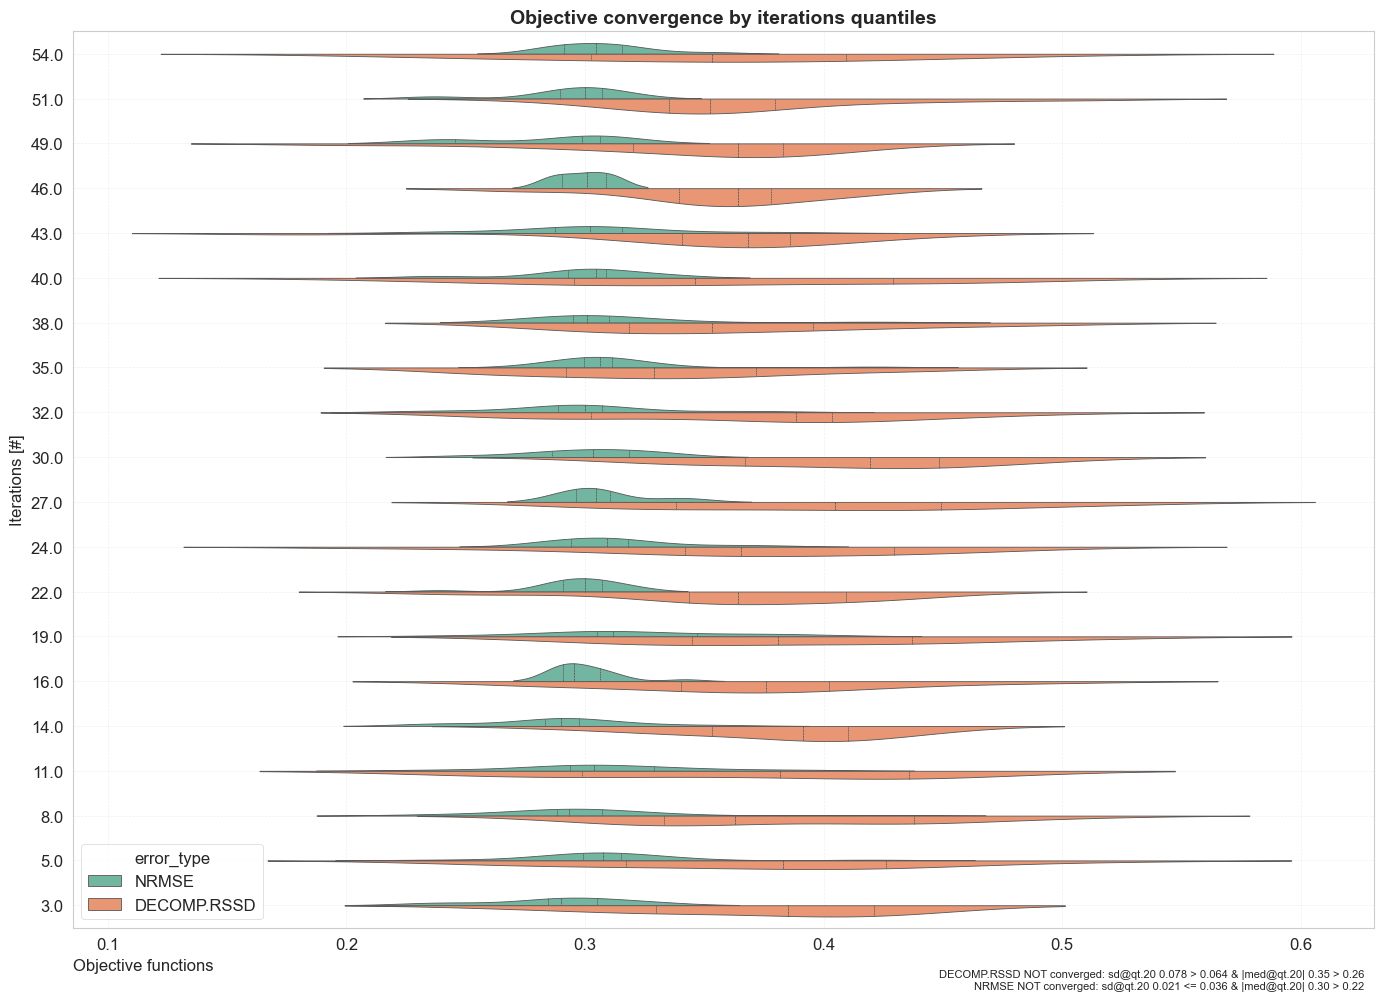

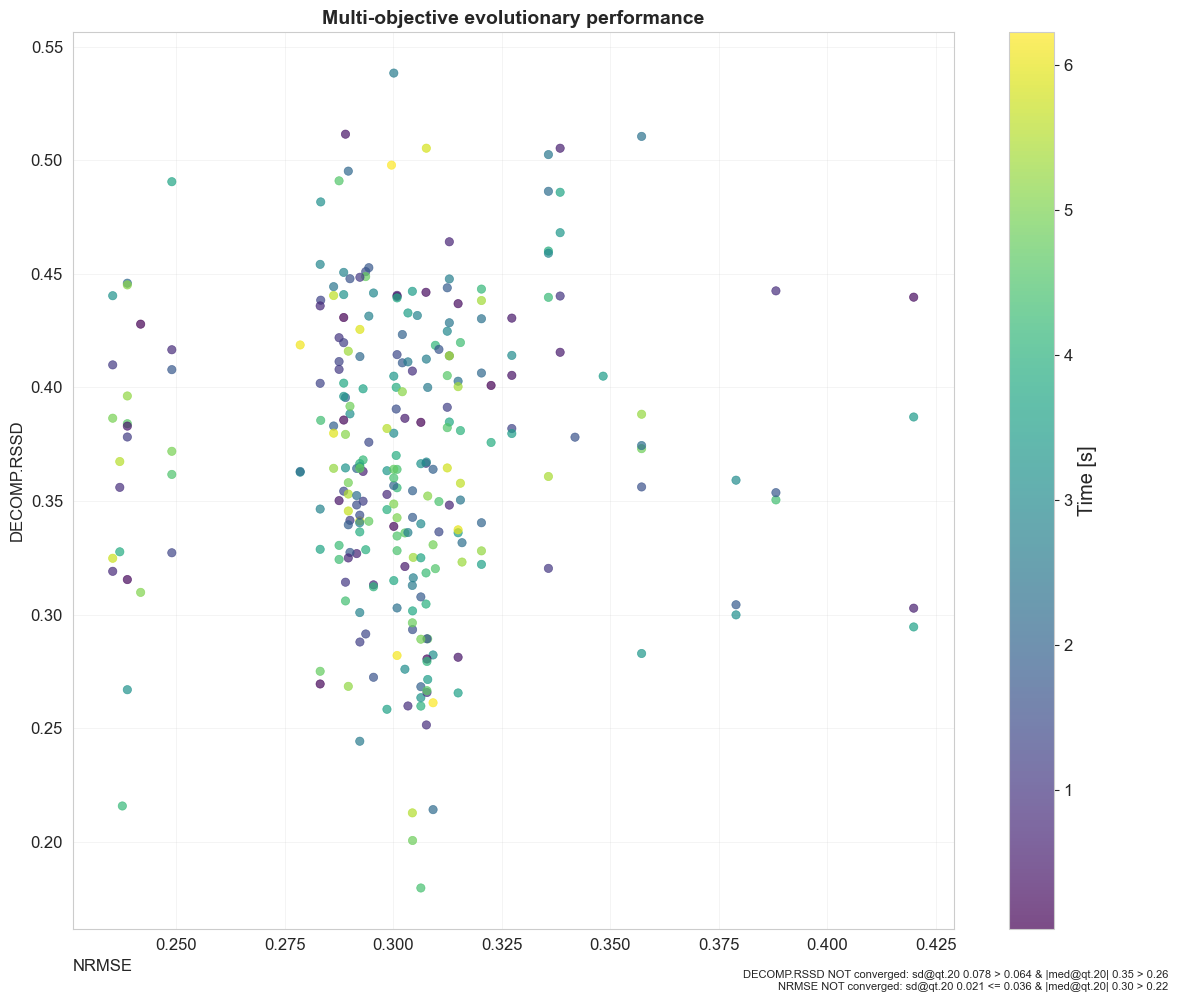

In [9]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(
    iterations=54, trials=5
)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on x cores..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

In [10]:
from robyn.tutorials.utils.data_mapper import load_data_from_json, import_input_collect, import_output_models
%load_ext autoreload
%autoreload 2

# Load data from JSON exported from R
raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_InputCollect.json"
)
raw_output_models = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_OutputModels.json"
)

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_models = import_output_models(raw_output_models)

# Extract individual components
r_mmm_data = r_input_collect["mmm_data"]
r_featurized_mmm_data = r_input_collect["featurized_mmm_data"]
r_holidays_data = r_input_collect["holidays_data"]
r_hyperparameters = r_input_collect["hyperparameters"]

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00
Raw hyperparameters data: {'facebook_S_alphas': [0.5, 3], 'facebook_S_gammas': [0.3, 1], 'facebook_S_thetas': [0, 0.3], 'print_S_alphas': [0.5, 3], 'print_S_gammas': [0.3, 1], 'print_S_thetas': [0.1, 0.4], 'tv_S_alphas': [0.5, 3], 'tv_S_gammas': [0.3, 1], 'tv_S_thetas': [0.3, 0.8], 'search_S_alphas': [0.5, 3], 'search_S_gammas': [0.3, 1], 'search_S_thetas': [0, 0.3], 'ooh_S_alphas': [0.5, 3], 'ooh_S_gammas': [0.3, 1], 'ooh_S_thetas': [0.1, 0.4], 'newsletter_alphas': [0.5, 3], 'newsletter_gammas': [0.3, 1], 'newsletter_thetas': [0.1, 0.4], 'train_size': [0.5, 0.8]}
Debug: R output data keys: ['trial1', 'trial2', 'trial3', 'trial4', 'trial5']
Data for trial1: Keys = ['resultCollect', 'hyperBoundNG', 'hyperBoundFixed']
Debug: resultCollect keys for trial1: ['resultHypParam', 'xDecompAgg', 'decompSpendDist', 'iter', 'elapsed.min']
Debug: Sample

In [11]:
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from dataclasses import is_dataclass, asdict
import pandas as pd


def build_tree(data, parent_key="", limit_trials=True):
    """
    Recursively build a tree structure from a dictionary, list, or dataclass.

    Args:
        data: The data structure (dict, list, or dataclass) to traverse.
        parent_key: The base key path for nested keys.
        limit_trials: Whether to limit the output to the first trial.

    Returns:
        A tree node representing the structure of the data.
    """
    if is_dataclass(data):
        data = asdict(data)  # Convert dataclass to dictionary

    if isinstance(data, dict):
        node = Node(parent_key)
        for key, value in data.items():
            full_key = f"{parent_key}.{key}" if parent_key else key
            child_node = build_tree(value, full_key, limit_trials)
            child_node.parent = node
        return node
    elif isinstance(data, list):
        node = Node(parent_key)
        for index, item in enumerate(data):
            if limit_trials and parent_key == "trials" and index > 0:
                break
            full_key = f"{parent_key}[{index}]"
            child_node = build_tree(item, full_key, limit_trials)
            child_node.parent = node
        return node
    elif isinstance(data, pd.DataFrame):
        node = Node(f"{parent_key} (DataFrame: {data.shape})")
        for column in data.columns:
            column_node = Node(f"{parent_key}.{column}")
            column_node.parent = node
        return node
    else:
        return Node(parent_key)


# Assuming output_models and r_output_models are instances of ModelOutputs
python_tree = build_tree(output_models)
r_tree = build_tree(r_output_models)

# Visualize the trees
print("Python ModelOutputs Structure:")
for pre, fill, node in RenderTree(python_tree):
    print(f"{pre}{node.name}")

print("\nR ModelOutputs Structure:")
for pre, fill, node in RenderTree(r_tree):
    print(f"{pre}{node.name}")

Python ModelOutputs Structure:

├── trials
│   └── trials[0]
│       ├── trials[0].result_hyp_param (DataFrame: (54, 39))
│       │   ├── trials[0].result_hyp_param.facebook_S_thetas
│       │   ├── trials[0].result_hyp_param.facebook_S_alphas
│       │   ├── trials[0].result_hyp_param.facebook_S_gammas
│       │   ├── trials[0].result_hyp_param.print_S_thetas
│       │   ├── trials[0].result_hyp_param.print_S_alphas
│       │   ├── trials[0].result_hyp_param.print_S_gammas
│       │   ├── trials[0].result_hyp_param.tv_S_thetas
│       │   ├── trials[0].result_hyp_param.tv_S_alphas
│       │   ├── trials[0].result_hyp_param.tv_S_gammas
│       │   ├── trials[0].result_hyp_param.search_S_thetas
│       │   ├── trials[0].result_hyp_param.search_S_alphas
│       │   ├── trials[0].result_hyp_param.search_S_gammas
│       │   ├── trials[0].result_hyp_param.ooh_S_thetas
│       │   ├── trials[0].result_hyp_param.ooh_S_alphas
│       │   ├── trials[0].result_hyp_param.ooh_S_gammas
│       │  

In [12]:
import pandas as pd
import numpy as np
from typing import Dict, Any


def compare_model_values(py_output, r_output):
    """Compare key values between Python and R model outputs"""

    print("1. Basic Model Configuration Comparison:")
    basic_attrs = [
        "train_timestamp",
        "cores",
        "iterations",
        "intercept",
        "intercept_sign",
        "nevergrad_algo",
        "ts_validation",
        "add_penalty_factor",
    ]

    # Add debug prints
    print("\nDebugging attribute types:")
    for attr in basic_attrs:
        py_val = getattr(py_output, attr, None)
        r_val = getattr(r_output, attr, None)
        print(f"{attr:20s} - Python type: {type(py_val)} | R type: {type(r_val)}")
        print(f"{attr:20s} - Python value: {py_val} | R value: {r_val}")
        print("-" * 50)

    print("\n2. Trial Results Comparison (Descriptive Statistics):")
    if py_output.trials and r_output.trials:
        metrics = [
            "nrmse",
            "decomp_rssd",
            "mape",
            "rsq_train",
            "rsq_val",
            "rsq_test",
            "lambda_",
            "lambda_hp",
            "lambda_max",
            "lambda_min_ratio",
        ]
        # Convert trial results to DataFrames
        py_trials_df = pd.DataFrame(
            [
                {metric: getattr(trial, metric, np.nan) for metric in metrics}
                for trial in py_output.trials
            ]
        )

        # Aggregate R trial metrics
        r_trials_df = pd.DataFrame(
            [
                {
                    metric: getattr(trial, metric, pd.Series([np.nan])).mean()
                    for metric in metrics
                }
                for trial in r_output.trials
            ]
        )
        # Ensure R trial data is numeric
        r_trials_df = r_trials_df.apply(pd.to_numeric, errors="coerce")
        # Calculate descriptive statistics
        py_desc = py_trials_df.describe()
        r_desc = r_trials_df.describe()
        # Print descriptive statistics
        print("\nPython Trial Descriptive Statistics:")
        print(py_desc)
        print("\nR Trial Descriptive Statistics:")
        print(r_desc)
        # Calculate and print differences
        diff_desc = py_desc - r_desc
        print("\nDifference in Descriptive Statistics:")
        print(diff_desc)

    print("\n3. Hyperparameter Comparison:")
    if hasattr(py_output, "hyper_updated") and hasattr(r_output, "hyper_updated"):
        py_hyper = py_output.hyper_updated
        r_hyper = r_output.hyper_updated

        # Find all unique keys
        all_keys = set(py_hyper.keys()) | set(r_hyper.keys())

        print("\nHyperparameter Values:")
        print(f"{'Parameter':30s} {'Python':>15s} {'R':>15s} {'Diff':>15s}")
        print("-" * 75)

        for key in sorted(all_keys):
            py_val = py_hyper.get(key, "N/A")
            r_val = r_hyper.get(key, "N/A")

            if isinstance(py_val, (int, float)) and isinstance(r_val, (int, float)):
                diff = abs(py_val - r_val)
                print(f"{key:30s} {py_val:15.6f} {r_val:15.6f} {diff:15.6f}")
            else:
                print(f"{key:30s} {str(py_val):15s} {str(r_val):15s} {'N/A':>15s}")

    print("\n4. Data Shape Comparison:")
    data_attrs = ["all_result_hyp_param", "all_x_decomp_agg", "all_decomp_spend_dist"]

    for attr in data_attrs:
        py_shape = getattr(py_output, attr).shape if hasattr(py_output, attr) else None
        r_shape = getattr(r_output, attr).shape if hasattr(r_output, attr) else None
        print(f"{attr:20s} - Python shape: {py_shape} | R shape: {r_shape}")


# Run the comparison
print("Starting detailed value comparison...\n")
compare_model_values(output_models, r_output_models)

Starting detailed value comparison...

1. Basic Model Configuration Comparison:

Debugging attribute types:
train_timestamp      - Python type: <class 'str'> | R type: <class 'str'>
train_timestamp      - Python value: 2024-11-21 02:31:49 | R value: 2024-11-21 02:30:29
--------------------------------------------------
cores                - Python type: <class 'int'> | R type: <class 'int'>
cores                - Python value: 8 | R value: 9
--------------------------------------------------
iterations           - Python type: <class 'int'> | R type: <class 'int'>
iterations           - Python value: 54 | R value: 50
--------------------------------------------------
intercept            - Python type: <class 'bool'> | R type: <class 'bool'>
intercept            - Python value: True | R value: True
--------------------------------------------------
intercept_sign       - Python type: <class 'str'> | R type: <class 'str'>
intercept_sign       - Python value: non_negative | R value: non

In [13]:
# Function to print model output summary
def print_model_output_summary(model_name, model):
    print(f"\n{model_name} Model Output Summary:")
    print(f"Number of trials: {len(model.trials)}")
    print(
        f"Average models per trial: {len(model.all_result_hyp_param) / len(model.trials)}"
    )
    print(f"Total unique models: {len(model.all_result_hyp_param['sol_id'].unique())}")

    print("\nMetrics Distribution:")
    metrics_df = model.all_result_hyp_param[["nrmse", "decomp.rssd", "mape"]]
    print(metrics_df.describe())

    # Additional validation to debug model output
    print("\nColumns in result_hyp_param:")
    print(model.all_result_hyp_param.columns.tolist())

    print("\nSample rows of metrics:")
    print(model.all_result_hyp_param[["sol_id", "nrmse", "decomp.rssd", "mape"]].head())

    # Show shape of result dataframes
    print("\nDataFrame Shapes:")
    print(f"result_hyp_param: {model.all_result_hyp_param.shape}")
    print(f"x_decomp_agg: {model.all_x_decomp_agg.shape}")
    print(f"decomp_spend_dist: {model.all_decomp_spend_dist.shape}")


# Print summaries for both output_models and r_output_models
print_model_output_summary("Python Output Models", output_models)
print_model_output_summary("R Output Models", r_output_models)


Python Output Models Model Output Summary:
Number of trials: 5
Average models per trial: 54.0
Total unique models: 270

Metrics Distribution:
            nrmse  decomp.rssd   mape
count  270.000000   270.000000  270.0
mean     0.302040     0.368954    0.0
std      0.030736     0.063796    0.0
min      0.235413     0.179811    0.0
25%      0.289696     0.327317    0.0
50%      0.300926     0.364911    0.0
75%      0.312495     0.414367    0.0
max      0.419955     0.538310    0.0

Columns in result_hyp_param:
['facebook_S_thetas', 'facebook_S_alphas', 'facebook_S_gammas', 'print_S_thetas', 'print_S_alphas', 'print_S_gammas', 'tv_S_thetas', 'tv_S_alphas', 'tv_S_gammas', 'search_S_thetas', 'search_S_alphas', 'search_S_gammas', 'ooh_S_thetas', 'ooh_S_alphas', 'ooh_S_gammas', 'newsletter_thetas', 'newsletter_alphas', 'newsletter_gammas', 'lambda', 'train_size', 'sol_id', 'Elapsed', 'ElapsedAccum', 'pos', 'trial', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse', 'nrmse_train', 'nrmse_val', 'nrm

In [14]:
def print_data_structure(data):
    print("Columns:", data.columns.tolist())
    print("\nFirst row:", data.iloc[0].to_dict())
    print("\nShape:", data.shape)


# Assuming you want to print the structure for the first trial
first_trial_r = r_output_models.trials[0].decomp_spend_dist
first_trial_python = output_models.trials[0].decomp_spend_dist

print("R exported data structure:")
print_data_structure(first_trial_r)

# With Python calculated data
print("\nPython calculated data structure:")
print_data_structure(first_trial_python)

R exported data structure:
Columns: ['rn', 'coef', 'xDecompAgg', 'xDecompPerc', 'xDecompMeanNon0', 'xDecompMeanNon0Perc', 'xDecompAggRF', 'xDecompPercRF', 'xDecompMeanNon0RF', 'xDecompMeanNon0PercRF', 'pos', 'mean_spend', 'total_spend', 'spend_share', 'spend_share_refresh', 'effect_share', 'effect_share_refresh', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse_train', 'nrmse_val', 'nrmse_test', 'nrmse', 'decomp.rssd', 'mape', 'lambda', 'lambda_hp', 'lambda_max', 'lambda_min_ratio', 'sol_id', 'trial', 'iterNG', 'iterPar']

First row: {'rn': 'tv_S', 'coef': 85541.42082097995, 'xDecompAgg': 2170906.4549621465, 'xDecompPerc': 0.007778859372366383, 'xDecompMeanNon0': 13827.429649440432, 'xDecompMeanNon0Perc': 0.00775628544138919, 'xDecompAggRF': 2170906.4549621465, 'xDecompPercRF': 0.007778859372366383, 'xDecompMeanNon0RF': 13827.429649440432, 'xDecompMeanNon0PercRF': 0.00775628544138919, 'pos': True, 'mean_spend': 16505.80985031847, 'total_spend': 2591412.1465000007, 'spend_share': 0.2060473626